# Course Project (Jump point search)

In this notebook presented implementation of Jump Point Search algorithm (http://grastien.net/ban/articles/hg-aaai11.pdf) and its comparison with A* algorithm.

In [1]:
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt
import math
import time
%matplotlib inline
EPS = 0.000001


Bad key "text.kerning_factor" on line 4 in
/home/dell/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


### Grid map representation and allowed moves on a grid

Square grid map class represents agent's environment

- width -- the number of rows in grid
- height -- the number of columns in grid
- cells -- the binary matrix, which represents the grid. 0 - cell is traversable
1 - cell is blocked

You have to code the getNeigbors fucntions that allows both cardinal and diagonal moves, but dissalows cutting corners and squezzing (see below)

![1](./Image/сutcorners.png)

In [2]:
class Map:

    # Default constructor
    def __init__(self):
        self.width = 0
        self.height = 0
        self.cells = []
    
    # Initialization of map by string.
    def ReadFromString(self, cellStr, width, height):
        self.width = width
        self.height = height
        self.cells = [[0 for _ in range(width)] for _ in range(height)]
        cellLines = cellStr.split("\n")
        i = 0
        j = 0
        for l in cellLines:
            if len(l) != 0:
                j = 0
                for c in l:
                    if c == '.':
                        self.cells[i][j] = 0
                    elif c == '#':
                        self.cells[i][j] = 1
                    else:
                        continue
                    j += 1
                if j != width:
                    raise Exception("Size Error. Map width = ", j, ", but must be", width )
                
                i += 1

        if i != height:
            raise Exception("Size Error. Map height = ", i, ", but must be", height )
    
    # Initialization of map by list of cells.
    def SetGridCells(self, width, height, gridCells):
        self.width = width
        self.height = height
        self.cells = gridCells

    # Checks cell is on grid.
    def inBounds(self, i, j):
        return (0 <= j < self.width) and (0 <= i < self.height)
    
    # Checks cell is not obstacle.
    def Traversable(self, i, j):
        return not self.cells[i][j]

    # Creates a list of neighbour cells as (i,j) tuples.
    def GetNeighbors(self, i, j):
        neighbors = []
        delta = [[0, 1], [1, 0], [0, -1], [-1, 0]]
        delta_diag = [[1, 1], [1, -1], [-1, 1], [-1, -1]]
        diag_neigh = [([1, 0], [0, 1]), ([1, 0], [0, -1]), ([0, 1], [-1, 0]), ([-1, 0], [0, -1])]

        for d in delta:
            if self.inBounds(i + d[0], j + d[1]) and self.Traversable(i + d[0], j + d[1]):
                neighbors.append((i + d[0], j + d[1]))
        for d, d_neigh in zip(delta_diag, diag_neigh):
            if self.inBounds(i + d[0], j + d[1]) and self.Traversable(i + d[0], j + d[1]) and self.inBounds(i + d_neigh[0][0], j + d_neigh[0][1]) and self.Traversable(i + d_neigh[0][0], j + d_neigh[0][1]) and self.inBounds(i + d_neigh[1][0], j + d_neigh[1][1]) and self.Traversable(i + d_neigh[1][0], j + d_neigh[1][1]):
                neighbors.append((i + d[0], j + d[1]))
        return neighbors
    
    def GetPrunedNeighbours(self, i, j, parent_i, parent_j):
        '''
        Get current node coordinates and coordinates of its parent. Return pruned nodes according
        to jump point search algorithm - in this case function returns two lists:
        neigh_nodes - list, list of all pruned neighbours for current node (including forced neighbours)
        forced_neigh_nodes - list, list of all forced neighbours for current node
        '''
        parent_neighbours = self.GetNeighbors(parent_i, parent_j)
        # get current node neighbours and remove parent
        neighbours = self.GetNeighbors(i, j)
        neighbours.remove((parent_i, parent_j))
        # get all direct neighbours of parent except current node
        direct_parent_neighbours = [neigh for neigh in parent_neighbours if neigh in neighbours]
        if len(direct_parent_neighbours) == 0:
            # in this case all neighbours are forced
            return [], neighbours
        parent_curr_cost = CalculateCost(i, j, parent_i, parent_j)
        # check if parent is diagonal to current node
        parent_diag = True if abs(i - parent_i) + abs(j - parent_j) == 2 else False
        parent_curr_any_cost = {}
        parent_direct_cost = {}
        parent_any_cost = {}
        neigh_nodes = []
        forced_neigh_nodes = []
        # calc following path cost for every node: parent-curr-any_node
        for neigh in neighbours:
            parent_curr_any_cost[neigh] = parent_curr_cost + CalculateCost(neigh[0], neigh[1],
                                                                           i, j)
        for neigh in direct_parent_neighbours:
            parent_direct_cost[neigh] = CalculateCost(neigh[0], neigh[1],
                                                      parent_i, parent_j)
        # calc following path cost for every node: parent-direct_neigh_of_parent-any_node
        for neigh in neighbours:
            parent_any_cost[neigh] = min([parent_direct_cost[direct_neigh] + CalculateCost(neigh[0],
                                                                                           neigh[1], direct_neigh[0], direct_neigh[1]) for direct_neigh in direct_parent_neighbours])
        # get pruned neighbours
        if parent_diag:
            for neigh in neighbours:
                if parent_curr_any_cost[neigh] < parent_any_cost[neigh]:
                    neigh_nodes.append(neigh)
        else:
            for neigh in neighbours:
                if parent_curr_any_cost[neigh] <= parent_any_cost[neigh]:
                    neigh_nodes.append(neigh)
        # get forced neighbours
        # print(neigh_nodes, direct_parent_neighbours)
        for neigh in neigh_nodes:
            if min([CalculateCost(neigh[0], neigh[1], direct_neigh[0], direct_neigh[1]) for direct_neigh in direct_parent_neighbours]) >= math.sqrt(3) - EPS:
                forced_neigh_nodes.append(neigh)
        # neigh_nodes = [node for node in neigh_nodes if node not in forced_neigh_nodes]
        return neigh_nodes, forced_neigh_nodes

Computes a cost of transition from cell `(i1, j1)` to cell `(i2, j2)`

In [3]:
def CalculateCost(i1, j1, i2, j2):
    return math.sqrt((i1 - i2) ** 2 + (j1 - j2) ** 2)

### Node representation

Node class represents a search node

- i, j: coordinates of corresponding grid element
- g: g-value of the node
- h: h-value of the node
- F: f-value of the node
- parent: pointer to the parent-node 

In [4]:
class Node:
    def __init__(self, i = -1, j = -1, g = math.inf, h = math.inf, F = None, parent = None):
        self.i = i
        self.j = j
        self.g = g
        if F is None:
            self.F = self.g + h
        else:
            self.F = F        
        self.parent = parent
    
    def __eq__(self, other):
        return (self.i == other.i) and (self.j == other.j)

### Open and close sets implementation
A crucial part of any search algorithm (A* including) is the code for handling OPEN/CLOSED 'lists'. Ineffective implementation of these 'lists' may become a bottleneck, expecially for large instances. So try your best to implement OPEN and CLOSED efficiently and correctly.

In [5]:
class OpenBase:

    def __init__(self):
        pass
    
    def __len__(self):
        pass
    
    def __iter__(self):
        pass


    # isEmpty should inform whether the OPEN is exhausted or not
    # in the former case the search main loop should be interrupted
    def isEmpty(self):
        pass


    # AddNode is the method that puts (e.g. inserts or updates) the node to OPEN
    # When implementing it do not forget to handle all possible cases:
    # - node already in OPEN but the new g-value is better;
    # - node already in OPEN but the new g-value is worse;
    # - node is not in OPEN yet.
    def AddNode(self, item : Node):
        pass


    # GetBestNode is the method that finds the best node (the one with the lowest g or f-value),
    # removes it from OPEN and returns it
    def GetBestNode(self):
        pass

In [6]:
class YourOpen (OpenBase):
    def __init__(self):
        self.elements = {}
        self.Fvalues = {}
    
    def __iter__(self):
        return iter(self.elements.values())

    def __len__(self):
        return len(self.elements)

    def isEmpty(self):
        if len(self.elements) != 0:
            return False
        return True
    

    def GetBestNode(self):
        bestCoord = list(self.Fvalues.keys())[list(self.Fvalues.values()).index(min(self.Fvalues.values()))]
        best = self.elements.pop(bestCoord)
        del self.Fvalues[bestCoord]
        return best
    

    def AddNode(self, item : Node):
        key = str(item.i) + '_' + str(item.j)
        if self.elements.get(key, None) is not(None):
            buf = self.elements[key]
            if buf.g - item.g > 0.000005:
                buf.F = item.F
                buf.g = item.g
                buf.parent = item.parent
                self.elements[key] = buf
                self.Fvalues[key] = item.F
                return
            else:
                return
        self.elements[key] = item
        self.Fvalues[key] = item.F
        return

In [7]:
class ClosedBase:

    def __init__(self):
        pass

    def __iter__(self):
        pass
    
    def __len__(self):
        pass
    
    
    def AddNode(self, item : Node, *args):
        pass

    def WasExpanded(self, item : Node, *args):
        pass

In [8]:
class YourClosed (ClosedBase):
    def __init__(self):
        self.elements = dict()

    def __iter__(self):
        return iter(self.elements.values())
    
    def __len__(self):
        return len(self.elements)
    
    # AddNode is the method that inserts the node to CLOSED
    def AddNode(self, item : Node, *args):
        self.elements[str(item.i) + '_' + str(item.j)] = item

    # WasExpanded is the method that checks if a node has been expanded
    def WasExpanded(self, item : Node, *args):
        if self.elements.get(str(item.i) + '_' + str(item.j), None) is not(None):
            return True
        return False



## A* algorithm with different heuristics
Implement 3 different heuristic functions besides the given Manhattan distance - Diagonal distance, Chebyshev distance, Euclidean distance. After that, implement A* using YourOpen and YourClosed.

Importanly, your search algorithm needs to return the following:
- boolean flag indicating whether the path was found or not
- goal state (so you can reconstruct the path later using the parent pointers)
- Open and Closed 'lists' so you can use them for further analysis (i.e. computing how many nodes were created within the search process, how many expansions were made etc.)

In [9]:
def ManhattanDistance(i1, j1, i2, j2):
    return abs(abs(int(i1) - int(i2)) + abs(int(j1) - int(j2)))

In [10]:
def DiagonalDistance(i1, j1, i2, j2):
    dx = abs(i2 - i1)
    dy = abs(j2 - j1)
    # here we set c_d as sqrt(2) according to map format
    return abs(dx - dy) + math.sqrt(2) * min(dx, dy)


In [11]:
def ChebyshevDistance(i1, j1, i2, j2):
    return max(abs(i2 - i1), abs(j2 - j1))


In [12]:
def EuclidDistance(i1, j1, i2, j2):
    dx = abs(i2 - i1)
    dy = abs(j2 - j1)
    return math.sqrt(dx * dx + dy * dy)


In [13]:
def GetSuccesors(gridMap, currNode, goalNode, startNode):
    '''
    This function return succesors of current node according to JPS algorithm.
    '''
    steps = 0
    succesors = []
    parent = currNode.parent
    
    if parent is None:
        # our currNode is start node - so we hasn't parent and nothing is pruned
        neighbours = gridMap.GetNeighbors(currNode.i, currNode.j)
        forcedNeighbours = []
    else:
        neighbours, forcedNeighbours = gridMap.GetPrunedNeighbours(currNode.i, currNode.j,
                                                                   currNode.parent.i,
                                                                   currNode.parent.j)
    for neigh in neighbours:
        direction = (neigh[0] - currNode.i, neigh[1] - currNode.j)
        newNode, steps = jump(gridMap, (currNode.i, currNode.j), direction, startNode, goalNode, steps)
        if newNode is not None:
            succesors.append(newNode)
    return succesors, steps

In [14]:
def jump(gridMap, neigh, direction, startNode, goalNode, steps):
    '''
    Jump function from paper.
    '''
    steps += 1
    # make one step in current direction
    nextNode = (neigh[0] + direction[0], neigh[1] + direction[1])
    # check if our node is on map and not an obstacle
    currNeighbours = gridMap.GetNeighbors(neigh[0], neigh[1])
    if not (nextNode in currNeighbours):
        return None, steps
    if nextNode == (goalNode.i, goalNode.j):
        return nextNode, steps
    # check if nextNode has forced neighbours
    neighbours, forcedNeighbours = gridMap.GetPrunedNeighbours(nextNode[0], nextNode[1],
                                                               neigh[0], neigh[1])
    if len(forcedNeighbours) != 0:
        return nextNode, steps
    # check if direction is diagonal
    if abs(direction[0]) + abs(direction[1]) == 2:
        # calc d1 and d2 according to paper
        direction1 = (0, direction[1])
        direction2 = (direction[0], 0)
        for direct in [direction1, direction2]:
            if jump(gridMap, nextNode, direct, startNode, goalNode, steps) is not None:
                return nextNode, steps
    return jump(gridMap, nextNode, direction, startNode, goalNode, steps)

In [15]:
def JumpAStar(gridMap, iStart, jStart, iGoal, jGoal, heuristicFunction = ManhattanDistance):
    '''
    A* with JPS.
    '''
    OPEN = YourOpen()
    CLOSED = YourClosed()
    steps = 0
    startNode = Node(iStart, jStart, g=0, F=0)
    goalNode = Node(iGoal, jGoal)
    OPEN.AddNode(startNode)
    cl_time = 0
    add_time = 0
    get_time = 0
    while not(OPEN.isEmpty()):
        t11 = time.time()
        currNode = OPEN.GetBestNode()
        t0 = time.time()
        CLOSED.AddNode(currNode)
        t1 = time.time()
        cl_time += t1-t0
        get_time += t0-t11
        if currNode.__eq__(goalNode):
            print(cl_time, add_time, get_time)
            return (True, currNode, CLOSED, OPEN, steps)
        # get neighbours
        t34 = time.time()
        neighbors, buf_steps = GetSuccesors(gridMap, currNode, goalNode, startNode)#gridMap.GetNeighbors(i=currNode.i, j=currNode.j)
        steps += buf_steps
        t45 = time.time()
        get_time += t45-t34
        for neigh in neighbors:
            gValue = currNode.g + CalculateCost(currNode.i, currNode.j, neigh[0], neigh[1])
            Fvalue = gValue + heuristicFunction(iGoal, jGoal, neigh[0], neigh[1])
            bufNode = Node(neigh[0], neigh[1], g=gValue, F=Fvalue)
            if CLOSED.WasExpanded(bufNode):
                continue
            t2 = time.time()
            OPEN.AddNode(bufNode)
            t3 = time.time()
            add_time += t3-t2
    return False, None, CLOSED, OPEN, steps

In [16]:
def AStar(gridMap, iStart, jStart, iGoal, jGoal, heuristicFunction = ManhattanDistance):
    OPEN = YourOpen()
    CLOSED = YourClosed()
    startNode = Node(iStart, jStart, g=0, F=0)
    goalNode = Node(iGoal, jGoal)
    OPEN.AddNode(startNode)
    cl_time = 0
    add_time = 0
    get_time = 0
    while not(OPEN.isEmpty()):
        t11 = time.time()
        currNode = OPEN.GetBestNode()
        t0 = time.time()
        CLOSED.AddNode(currNode)
        t1 = time.time()
        cl_time += t1-t0
        get_time += t0-t11
        if currNode.__eq__(goalNode):
            print(cl_time, add_time, get_time)
            return (True, currNode, CLOSED, OPEN)
        # get neighbours
        t34 = time.time()
        neighbors = gridMap.GetNeighbors(i=currNode.i, j=currNode.j)
        t45 = time.time()
        get_time += t45-t34
        for neigh in neighbors:
            gValue = currNode.g + CalculateCost(currNode.i, currNode.j, neigh[0], neigh[1])
            Fvalue = gValue + heuristicFunction(iGoal, jGoal, neigh[0], neigh[1])
            bufNode = Node(neigh[0], neigh[1], g=gValue, F=Fvalue)
            if CLOSED.WasExpanded(bufNode):
                continue
            t2 = time.time()
            OPEN.AddNode(bufNode)
            t3 = time.time()
            add_time += t3-t2
    return False, None, CLOSED, OPEN

### Make Path
This is an auxiliary function that reconstructs a path (i.e. the sequence on moves from start to goal) given a search tree, created by the search algorithm. It basically unwinds the path using the parent pointers. It also returns a length of the path.

In [17]:
def MakePath(goal):
    length = goal.g
    current = goal
    path = []
    while current.parent:
        path.append(current)
        current = current.parent
    path.append(current)
    return path[::-1], length

### Simple Single Test
This function helps you to run a test of your search algorithm on a single instance (map + start + goal) and validate the result (provided that you know the correct answer to the path finding query and pass it as a parameter).

In [18]:
def SimpleTest(SearchFunction, height, width, mapstr, iStart, jStart, iGoal, jGoal, pathLen, *args):
    taskMap = Map()
    taskMap.ReadFromString(mapstr, width, height)
    start = Node(iStart, jStart)
    goal = Node(iGoal, jGoal)

    try:
        result = SearchFunction(taskMap, start.i, start.j, goal.i, goal.j, *args)
        nodesExpanded = result[2]
        nodesOpened = result[3]
        if result[0]:
            path = MakePath(result[1])
            correct = abs(path[1] - pathLen) < EPS
            print("Path found! Length: " + str(path[1]) + ". Nodes created: " + str(len(nodesOpened) + len(nodesExpanded)) + ". Number of steps: " + str(len(nodesExpanded)) + ". Correct: " + str(correct))
        else:
            print("Path not found!")
    except Exception as e:
        print("Execution error")
        print(e)

### Proccessing the Input Data and Storing the Results 


In [19]:
def ReadMapFromMovingAIFile(path):
    height = 0
    width = 0
    aimap = ''
    with open(path, 'r') as f:
        f.readline()
        height = int(f.readline().split()[-1])
        width = int(f.readline().split()[-1])
        f.readline()
        for line in f:
            buf = line
            buf = buf.replace('T', '#')
            buf = buf.replace('O', '#')
            buf = buf.replace('@', '#')
            buf = buf.replace('G', '.')
            # preproces our line to replace all cells to '.' or '#'
            aimap += buf
    return height, width, aimap


In [20]:
def ReadTasksFromMovingAIFile(path):
    tasks = []
    with open(path, 'r') as f:
        f.readline()
        for line in f:
            buf = line.split('\t')
            iStart, jStart, iGoal, jGoal, pathLen = list(map(float, buf[4:]))
            tasks.append([int(iStart), int(jStart),
                          int(iGoal), int(jGoal), pathLen])
    return tasks 

In [21]:
def MassiveTest(SearchFunction, mode='normal', *args):
    allTasksResults = dict()
    map_pathes = ['./Data/arena.map', './Data/den001d.map', './Data/Berlin_0_256.map']
    scen_pathes = ['./Data/arena.map.scen', './Data/den001d.map.scen', './Data/Berlin_0_256.map.scen']
    # iterate over maps
    index = 0
    for maps, scen in zip(map_pathes, scen_pathes):
        height, width, aimap = ReadMapFromMovingAIFile(maps)
        # get only first 150 tasks
        tasks = ReadTasksFromMovingAIFile(scen)[:150]
        taskMap = Map()
        taskMap.ReadFromString(aimap, width, height)
        for task in tasks:
            jStart, iStart, jGoal, iGoal, pathLen = task
            start = Node(iStart, jStart)
            goal = Node(iGoal, jGoal)
            try:
                #for k in range(1):
                result = SearchFunction(taskMap, start.i, start.j, goal.i, goal.j, *args)
                nodesExpanded = result[2]
                nodesOpened = result[3]
                if result[0]:
                    path = MakePath(result[1])
                    correct = abs(path[1] - pathLen) < EPS
                    if mode == 'normal':
                        print("Path found! Length: " + str(path[1]) + ". Nodes created: " + str(len(nodesOpened) + len(nodesExpanded)) + ". Number of steps: " + str(len(nodesExpanded)) + ". Correct: " + str(correct) + '. Jump steps:' + str(len(nodesExpanded)))
                        allTasksResults[index] = [len(nodesOpened), len(nodesExpanded), correct, True, path[1], pathLen, len(nodesExpanded)]
                    else:
                        print("Path found! Length: " + str(path[1]) + ". Nodes created: " + str(len(nodesOpened) + len(nodesExpanded)) + ". Number of steps: " + str(len(nodesExpanded)) + ". Correct: " + str(correct) + '. Jump steps:' + str(result[-1]))
                        allTasksResults[index] = [len(nodesOpened), len(nodesExpanded), correct, True, path[1], pathLen, result[-1]]
                else:
                    print("Path not found!")
                    allTasksResults[index] = [len(nodesOpened), len(nodesExpanded), False, False, 0, pathLen, results[-1]]
                index += 1
            except Exception as e:
                print("Execution error")
                print(e)

    return allTasksResults

## Now it's time to run simple test

In [22]:
height = 15
width = 30
mapstr = '''
. . . . . . . . . . . . . . . . . . . . . # # . . . . . . .  
. . . . . . . . . . . . . . . . . . . . . # # . . . . . . . 
. . . . . . . . . . . . . . . . . . . . . # # . . . . . . . 
. . . # # . . . . . . . . . . . . . . . . # # . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . # # . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . # # # # # . . . . 
. . . # # . . . . . . . . # # . . . . . . # # # # # . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . # # . . . . . . . . . . . . . . .
. . . . . . . . . . . . . # # . . . . . . . . . . . . . . .
'''
iStart = 1
jStart = 1
iGoal = 13
jGoal = 28
pathLen = 31.9705627


In [23]:
%time SimpleTest(AStar, height, width, mapstr, iStart, jStart, iGoal, jGoal, pathLen, ManhattanDistance)

0.00013184547424316406 0.00067901611328125 0.0021126270294189453
Path found! Length: 31.970562748477146. Nodes created: 191. Number of steps: 103. Correct: True
CPU times: user 6.5 ms, sys: 277 µs, total: 6.78 ms
Wall time: 6.62 ms


In [24]:
%time SimpleTest(JumpAStar, height, width, mapstr, iStart, jStart, iGoal, jGoal, pathLen, ManhattanDistance)

7.2479248046875e-05 0.00022673606872558594 0.09693622589111328
Path found! Length: 31.970562748477146. Nodes created: 82. Number of steps: 34. Correct: True
CPU times: user 98 ms, sys: 0 ns, total: 98 ms
Wall time: 98.7 ms


In [25]:
%time SimpleTest(AStar, height, width, mapstr, iStart, jStart, iGoal, jGoal, pathLen, DiagonalDistance)

0.00013113021850585938 0.0006871223449707031 0.002301454544067383
Path found! Length: 31.97056274847715. Nodes created: 185. Number of steps: 105. Correct: True
CPU times: user 6.9 ms, sys: 161 µs, total: 7.06 ms
Wall time: 6.87 ms


In [26]:
%time SimpleTest(AStar, height, width, mapstr, iStart, jStart, iGoal, jGoal, pathLen, ChebyshevDistance)

0.0005567073822021484 0.0025191307067871094 0.010107278823852539
Path found! Length: 31.97056274847715. Nodes created: 239. Number of steps: 192. Correct: True
CPU times: user 26 ms, sys: 0 ns, total: 26 ms
Wall time: 25.7 ms


In [27]:
%time SimpleTest(AStar, height, width, mapstr, iStart, jStart, iGoal, jGoal, pathLen, EuclidDistance) 

0.00018334388732910156 0.0011119842529296875 0.002858877182006836
Path found! Length: 31.970562748477146. Nodes created: 214. Number of steps: 147. Correct: True
CPU times: user 9.75 ms, sys: 167 µs, total: 9.91 ms
Wall time: 9.37 ms


## Massive test


In [28]:
%time manh_mass = MassiveTest(AStar, 'normal', ManhattanDistance)

1.1205673217773438e-05 5.8650970458984375e-05 0.0001361370086669922
Path found! Length: 3.0. Nodes created: 15. Number of steps: 4. Correct: True. Jump steps:4
7.152557373046875e-06 3.814697265625e-05 8.463859558105469e-05
Path found! Length: 2.414213562373095. Nodes created: 14. Number of steps: 3. Correct: True. Jump steps:3
9.298324584960938e-06 4.076957702636719e-05 0.00010037422180175781
Path found! Length: 2.0. Nodes created: 12. Number of steps: 3. Correct: True. Jump steps:3
5.0067901611328125e-06 2.002716064453125e-05 5.7697296142578125e-05
Path found! Length: 1.4142135623730951. Nodes created: 9. Number of steps: 2. Correct: True. Jump steps:2
9.059906005859375e-06 5.555152893066406e-05 0.00014495849609375
Path found! Length: 3.8284271247461903. Nodes created: 19. Number of steps: 4. Correct: True. Jump steps:4
8.58306884765625e-06 2.5272369384765625e-05 8.130073547363281e-05
Path found! Length: 2.0. Nodes created: 8. Number of steps: 3. Correct: True. Jump steps:3
4.52995300

4.315376281738281e-05 0.00026726722717285156 0.0006554126739501953
Path found! Length: 32.62741699796953. Nodes created: 116. Number of steps: 34. Correct: False. Jump steps:34
4.00543212890625e-05 0.00026297569274902344 0.0005927085876464844
Path found! Length: 29.69848480983501. Nodes created: 109. Number of steps: 22. Correct: True. Jump steps:22
3.504753112792969e-05 0.0002689361572265625 0.0005848407745361328
Path found! Length: 31.48528137423857. Nodes created: 105. Number of steps: 30. Correct: True. Jump steps:30
3.4332275390625e-05 0.0002765655517578125 0.0005815029144287109
Path found! Length: 32.65685424949238. Nodes created: 104. Number of steps: 33. Correct: False. Jump steps:33
4.3392181396484375e-05 0.00025177001953125 0.0005643367767333984
Path found! Length: 34.38477631085024. Nodes created: 119. Number of steps: 30. Correct: True. Jump steps:30
3.504753112792969e-05 0.00026679039001464844 0.0006108283996582031
Path found! Length: 35.798989873223334. Nodes created: 122

1.1444091796875e-05 7.581710815429688e-05 0.00015115737915039062
Path found! Length: 10.899494936611667. Nodes created: 41. Number of steps: 9. Correct: True. Jump steps:9
1.1205673217773438e-05 8.845329284667969e-05 0.00018930435180664062
Path found! Length: 9.0. Nodes created: 33. Number of steps: 10. Correct: True. Jump steps:10
1.239776611328125e-05 9.036064147949219e-05 0.00020956993103027344
Path found! Length: 8.82842712474619. Nodes created: 31. Number of steps: 9. Correct: True. Jump steps:9
1.0728836059570312e-05 7.772445678710938e-05 0.00017213821411132812
Path found! Length: 8.0. Nodes created: 30. Number of steps: 9. Correct: True. Jump steps:9
1.2874603271484375e-05 9.298324584960938e-05 0.00018978118896484375
Path found! Length: 13.313708498984763. Nodes created: 50. Number of steps: 11. Correct: True. Jump steps:11
1.5974044799804688e-05 0.00013971328735351562 0.00025200843811035156
Path found! Length: 12.0. Nodes created: 42. Number of steps: 13. Correct: True. Jump st

3.504753112792969e-05 0.0002589225769042969 0.0005602836608886719
Path found! Length: 33.213203435596434. Nodes created: 117. Number of steps: 28. Correct: True. Jump steps:28
4.458427429199219e-05 0.0002830028533935547 0.0005943775177001953
Path found! Length: 32.14213562373095. Nodes created: 110. Number of steps: 29. Correct: True. Jump steps:29
3.6716461181640625e-05 0.00028824806213378906 0.0006184577941894531
Path found! Length: 32.242640687119284. Nodes created: 101. Number of steps: 32. Correct: True. Jump steps:32
3.0279159545898438e-05 0.00019168853759765625 0.00046706199645996094
Path found! Length: 32.213203435596434. Nodes created: 98. Number of steps: 27. Correct: True. Jump steps:27
0.00010156631469726562 0.0005972385406494141 0.0016679763793945312
Path found! Length: 34.65685424949238. Nodes created: 166. Number of steps: 94. Correct: True. Jump steps:94
4.4345855712890625e-05 0.0003342628479003906 0.000888824462890625
Path found! Length: 36.82842712474619. Nodes create

0.00029277801513671875 0.0020890235900878906 0.0048716068267822266
Path found! Length: 55.28427124746189. Nodes created: 293. Number of steps: 163. Correct: True. Jump steps:163
5.602836608886719e-05 0.0003666877746582031 0.0009555816650390625
Path found! Length: 53.87005768508882. Nodes created: 167. Number of steps: 47. Correct: True. Jump steps:47
0.0010023117065429688 0.006006956100463867 0.015940189361572266
Path found! Length: 52.87005768508881. Nodes created: 767. Number of steps: 652. Correct: True. Jump steps:652
0.000858306884765625 0.0036585330963134766 0.012871265411376953
Path found! Length: 52.55634918610404. Nodes created: 709. Number of steps: 612. Correct: True. Jump steps:612
6.341934204101562e-05 0.0004546642303466797 0.0011267662048339844
Path found! Length: 53.87005768508882. Nodes created: 178. Number of steps: 48. Correct: True. Jump steps:48
7.867813110351562e-05 0.00049591064453125 0.0011315345764160156
Path found! Length: 59.41421356237309. Nodes created: 183.

3.647804260253906e-05 0.00027108192443847656 0.0005910396575927734
Path found! Length: 31.65685424949238. Nodes created: 103. Number of steps: 31. Correct: True. Jump steps:31
4.2438507080078125e-05 0.0003139972686767578 0.0007078647613525391
Path found! Length: 31.242640687119284. Nodes created: 99. Number of steps: 31. Correct: True. Jump steps:31
6.890296936035156e-05 0.0003528594970703125 0.0009677410125732422
Path found! Length: 29.72792206135786. Nodes created: 117. Number of steps: 57. Correct: True. Jump steps:57
4.553794860839844e-05 0.00025653839111328125 0.0005779266357421875
Path found! Length: 35.14213562373095. Nodes created: 119. Number of steps: 32. Correct: True. Jump steps:32
3.6716461181640625e-05 0.0002663135528564453 0.0006201267242431641
Path found! Length: 35.213203435596434. Nodes created: 121. Number of steps: 31. Correct: True. Jump steps:31
0.0002243518829345703 0.0010633468627929688 0.0042057037353515625
Path found! Length: 35.112698372208094. Nodes created:

5.1975250244140625e-05 0.0003762245178222656 0.0009357929229736328
Path found! Length: 55.32590180780449. Nodes created: 200. Number of steps: 41. Correct: True. Jump steps:41
6.318092346191406e-05 0.0005078315734863281 0.0010845661163330078
Path found! Length: 52.242640687119284. Nodes created: 165. Number of steps: 52. Correct: True. Jump steps:52
5.984306335449219e-05 0.0004668235778808594 0.0010902881622314453
Path found! Length: 53.55634918610405. Nodes created: 175. Number of steps: 50. Correct: True. Jump steps:50
5.8650970458984375e-05 0.0004119873046875 0.0010471343994140625
Path found! Length: 55.76955262170047. Nodes created: 192. Number of steps: 48. Correct: False. Jump steps:48
7.486343383789062e-05 0.0005545616149902344 0.0012898445129394531
Path found! Length: 53.48528137423857. Nodes created: 170. Number of steps: 52. Correct: True. Jump steps:52
5.245208740234375e-05 0.00039386749267578125 0.0009207725524902344
Path found! Length: 53.59797974644666. Nodes created: 188

In [29]:
%time diag_mass = MassiveTest(AStar, 'normal', DiagonalDistance)

5.7220458984375e-06 3.170967102050781e-05 7.605552673339844e-05
Path found! Length: 3.0. Nodes created: 15. Number of steps: 4. Correct: True. Jump steps:4
5.7220458984375e-06 3.0994415283203125e-05 6.508827209472656e-05
Path found! Length: 2.414213562373095. Nodes created: 15. Number of steps: 4. Correct: True. Jump steps:4
3.5762786865234375e-06 2.193450927734375e-05 4.315376281738281e-05
Path found! Length: 2.0. Nodes created: 12. Number of steps: 3. Correct: True. Jump steps:3
2.384185791015625e-06 1.33514404296875e-05 2.4557113647460938e-05
Path found! Length: 1.4142135623730951. Nodes created: 9. Number of steps: 2. Correct: True. Jump steps:2
5.245208740234375e-06 3.314018249511719e-05 6.747245788574219e-05
Path found! Length: 3.82842712474619. Nodes created: 17. Number of steps: 4. Correct: True. Jump steps:4
6.4373016357421875e-06 1.6689300537109375e-05 5.841255187988281e-05
Path found! Length: 2.0. Nodes created: 8. Number of steps: 3. Correct: True. Jump steps:3
8.1062316894

9.107589721679688e-05 0.0005023479461669922 0.001528024673461914
Path found! Length: 23.071067811865476. Nodes created: 152. Number of steps: 82. Correct: True. Jump steps:82
0.00017499923706054688 0.00091552734375 0.002977609634399414
Path found! Length: 26.970562748477146. Nodes created: 239. Number of steps: 160. Correct: True. Jump steps:160
0.00014162063598632812 0.0007462501525878906 0.002501964569091797
Path found! Length: 24.72792206135786. Nodes created: 187. Number of steps: 129. Correct: True. Jump steps:129
7.343292236328125e-05 0.0004315376281738281 0.0012173652648925781
Path found! Length: 27.82842712474619. Nodes created: 125. Number of steps: 66. Correct: True. Jump steps:66
6.866455078125e-05 0.00038933753967285156 0.0011706352233886719
Path found! Length: 24.213203435596434. Nodes created: 135. Number of steps: 64. Correct: True. Jump steps:64
7.867813110351562e-05 0.0005340576171875 0.001394033432006836
Path found! Length: 26.65685424949238. Nodes created: 168. Numbe

0.00026917457580566406 0.0013420581817626953 0.00471949577331543
Path found! Length: 45.28427124746189. Nodes created: 342. Number of steps: 233. Correct: True. Jump steps:233
0.0002689361572265625 0.0014030933380126953 0.004809856414794922
Path found! Length: 46.455844122715696. Nodes created: 359. Number of steps: 244. Correct: True. Jump steps:244
0.0001766681671142578 0.0009191036224365234 0.003053903579711914
Path found! Length: 47.59797974644664. Nodes created: 286. Number of steps: 164. Correct: True. Jump steps:164
0.00026297569274902344 0.0014574527740478516 0.004710197448730469
Path found! Length: 44.14213562373094. Nodes created: 372. Number of steps: 240. Correct: True. Jump steps:240
0.0002276897430419922 0.0010921955108642578 0.0034875869750976562
Path found! Length: 45.769552621700456. Nodes created: 302. Number of steps: 176. Correct: True. Jump steps:176
0.0002505779266357422 0.0012581348419189453 0.0044689178466796875
Path found! Length: 46.870057685088796. Nodes crea

7.343292236328125e-05 0.0004112720489501953 0.0011856555938720703
Path found! Length: 17.313708498984763. Nodes created: 112. Number of steps: 63. Correct: True. Jump steps:63
3.457069396972656e-05 0.00016689300537109375 0.0005145072937011719
Path found! Length: 18.899494936611667. Nodes created: 65. Number of steps: 32. Correct: True. Jump steps:32
2.956390380859375e-05 0.00014495849609375 0.0004050731658935547
Path found! Length: 16.656854249492383. Nodes created: 59. Number of steps: 26. Correct: True. Jump steps:26
2.7418136596679688e-05 0.0001780986785888672 0.0004363059997558594
Path found! Length: 17.970562748477146. Nodes created: 81. Number of steps: 26. Correct: True. Jump steps:26
6.318092346191406e-05 0.0003693103790283203 0.001010894775390625
Path found! Length: 19.970562748477146. Nodes created: 111. Number of steps: 52. Correct: True. Jump steps:52
5.1021575927734375e-05 0.00030875205993652344 0.0008175373077392578
Path found! Length: 17.242640687119284. Nodes created: 9

0.0002028942108154297 0.0010216236114501953 0.0034341812133789062
Path found! Length: 39.79898987322333. Nodes created: 253. Number of steps: 162. Correct: True. Jump steps:162
0.0001983642578125 0.0010943412780761719 0.0033278465270996094
Path found! Length: 36.31370849898475. Nodes created: 267. Number of steps: 154. Correct: True. Jump steps:154
0.0002446174621582031 0.0012600421905517578 0.004308462142944336
Path found! Length: 39.284271247461895. Nodes created: 325. Number of steps: 217. Correct: True. Jump steps:217
0.00019311904907226562 0.0009582042694091797 0.0033783912658691406
Path found! Length: 36.62741699796952. Nodes created: 238. Number of steps: 160. Correct: True. Jump steps:160
0.00010561943054199219 0.0005695819854736328 0.0016751289367675781
Path found! Length: 38.24264068711928. Nodes created: 162. Number of steps: 85. Correct: True. Jump steps:85
8.702278137207031e-05 0.0005748271942138672 0.0015399456024169922
Path found! Length: 36.35533905932738. Nodes created

0.0008273124694824219 0.003686666488647461 0.015261411666870117
Path found! Length: 52.556349186104036. Nodes created: 806. Number of steps: 718. Correct: True. Jump steps:718
0.0004105567932128906 0.0015745162963867188 0.005228519439697266
Path found! Length: 53.87005768508878. Nodes created: 405. Number of steps: 275. Correct: True. Jump steps:275
0.00013065338134765625 0.0007314682006835938 0.0023059844970703125
Path found! Length: 59.41421356237309. Nodes created: 226. Number of steps: 117. Correct: True. Jump steps:117
0.00039649009704589844 0.0017321109771728516 0.006153583526611328
Path found! Length: 58.76955262170044. Nodes created: 435. Number of steps: 327. Correct: True. Jump steps:327
0.0002942085266113281 0.0007295608520507812 0.0021276473999023438
Path found! Length: 58.242640687119284. Nodes created: 207. Number of steps: 94. Correct: True. Jump steps:94
0.0011551380157470703 0.005427122116088867 0.020943164825439453
Path found! Length: 57.89949493661166. Nodes created:

Path found! Length: 16.0. Nodes created: 54. Number of steps: 17. Correct: True. Jump steps:17
8.630752563476562e-05 0.00043511390686035156 0.0012755393981933594
Path found! Length: 19.55634918610405. Nodes created: 117. Number of steps: 60. Correct: True. Jump steps:60
7.915496826171875e-05 0.0004429817199707031 0.0012919902801513672
Path found! Length: 18.72792206135786. Nodes created: 123. Number of steps: 70. Correct: True. Jump steps:70
2.002716064453125e-05 0.00015425682067871094 0.00031280517578125
Path found! Length: 16.0. Nodes created: 54. Number of steps: 17. Correct: True. Jump steps:17
4.982948303222656e-05 0.0003123283386230469 0.0007960796356201172
Path found! Length: 21.414213562373096. Nodes created: 91. Number of steps: 42. Correct: True. Jump steps:42
5.5789947509765625e-05 0.0002582073211669922 0.0008330345153808594
Path found! Length: 22.899494936611667. Nodes created: 89. Number of steps: 49. Correct: True. Jump steps:49
4.792213439941406e-05 0.0002920627593994140

0.000244140625 0.0012013912200927734 0.00423121452331543
Path found! Length: 36.556349186104036. Nodes created: 276. Number of steps: 196. Correct: True. Jump steps:196
0.00017452239990234375 0.0009660720825195312 0.002819061279296875
Path found! Length: 38.11269837220809. Nodes created: 239. Number of steps: 156. Correct: True. Jump steps:156
3.218650817871094e-05 0.0002491474151611328 0.0005316734313964844
Path found! Length: 38.18376618407357. Nodes created: 139. Number of steps: 28. Correct: True. Jump steps:28
8.20159912109375e-05 0.0005533695220947266 0.0014395713806152344
Path found! Length: 39.41421356237309. Nodes created: 163. Number of steps: 78. Correct: True. Jump steps:78
0.000209808349609375 0.0011448860168457031 0.0037622451782226562
Path found! Length: 38.38477631085023. Nodes created: 294. Number of steps: 196. Correct: True. Jump steps:196
0.0002262592315673828 0.0011861324310302734 0.00406956672668457
Path found! Length: 37.04163056034261. Nodes created: 276. Number

0.00024008750915527344 0.0011949539184570312 0.004658699035644531
Path found! Length: 57.79898987322332. Nodes created: 305. Number of steps: 197. Correct: True. Jump steps:197
0.00019311904907226562 0.0010862350463867188 0.003275156021118164
Path found! Length: 59.18376618407352. Nodes created: 299. Number of steps: 158. Correct: True. Jump steps:158
0.0001437664031982422 0.0008866786956787109 0.002756834030151367
Path found! Length: 59.485281374238554. Nodes created: 259. Number of steps: 125. Correct: True. Jump steps:125
0.00029087066650390625 0.0013988018035888672 0.005018711090087891
Path found! Length: 58.21320343559643. Nodes created: 355. Number of steps: 243. Correct: True. Jump steps:243
0.0001537799835205078 0.0009496212005615234 0.002763509750366211
Path found! Length: 56.28427124746185. Nodes created: 253. Number of steps: 107. Correct: True. Jump steps:107
9.369850158691406e-05 0.0005924701690673828 0.001569986343383789
Path found! Length: 56.15432893255067. Nodes create

In [30]:
%time cheb_mass = MassiveTest(AStar, 'normal', ChebyshevDistance)

9.059906005859375e-06 5.841255187988281e-05 0.0001366138458251953
Path found! Length: 3.0. Nodes created: 15. Number of steps: 4. Correct: True. Jump steps:4
9.298324584960938e-06 5.626678466796875e-05 0.00012969970703125
Path found! Length: 2.414213562373095. Nodes created: 15. Number of steps: 4. Correct: True. Jump steps:4
4.76837158203125e-06 2.4557113647460938e-05 5.650520324707031e-05
Path found! Length: 2.0. Nodes created: 12. Number of steps: 3. Correct: True. Jump steps:3
2.6226043701171875e-06 1.4543533325195312e-05 3.075599670410156e-05
Path found! Length: 1.4142135623730951. Nodes created: 9. Number of steps: 2. Correct: True. Jump steps:2
5.9604644775390625e-06 3.910064697265625e-05 8.440017700195312e-05
Path found! Length: 3.82842712474619. Nodes created: 18. Number of steps: 5. Correct: True. Jump steps:5
8.106231689453125e-06 2.9802322387695312e-05 9.059906005859375e-05
Path found! Length: 2.0. Nodes created: 8. Number of steps: 3. Correct: True. Jump steps:3
1.04904174

0.00018548965454101562 0.0009424686431884766 0.003213167190551758
Path found! Length: 22.313708498984766. Nodes created: 240. Number of steps: 167. Correct: True. Jump steps:167
0.00021839141845703125 0.001119375228881836 0.0039899349212646484
Path found! Length: 23.485281374238575. Nodes created: 251. Number of steps: 180. Correct: True. Jump steps:180
0.00010943412780761719 0.0005533695220947266 0.0016696453094482422
Path found! Length: 21.82842712474619. Nodes created: 145. Number of steps: 94. Correct: True. Jump steps:94
0.0001957416534423828 0.00101470947265625 0.0030260086059570312
Path found! Length: 20.142135623730955. Nodes created: 192. Number of steps: 124. Correct: True. Jump steps:124
0.0002238750457763672 0.001066446304321289 0.0033855438232421875
Path found! Length: 20.55634918610405. Nodes created: 195. Number of steps: 130. Correct: True. Jump steps:130
0.0003235340118408203 0.001684427261352539 0.005947113037109375
Path found! Length: 21.89949493661167. Nodes created

0.0005633831024169922 0.0026400089263916016 0.010267019271850586
Path found! Length: 38.970562748477136. Nodes created: 592. Number of steps: 475. Correct: True. Jump steps:475
0.0005233287811279297 0.0025687217712402344 0.00960683822631836
Path found! Length: 39.698484809834994. Nodes created: 598. Number of steps: 485. Correct: True. Jump steps:485
0.0006842613220214844 0.003276824951171875 0.01216268539428711
Path found! Length: 43.04163056034262. Nodes created: 570. Number of steps: 488. Correct: True. Jump steps:488
0.0005693435668945312 0.0034322738647460938 0.009537696838378906
Path found! Length: 40.35533905932737. Nodes created: 552. Number of steps: 450. Correct: True. Jump steps:450
0.0005621910095214844 0.002731800079345703 0.010602235794067383
Path found! Length: 40.38477631085023. Nodes created: 597. Number of steps: 480. Correct: True. Jump steps:480
0.0006282329559326172 0.002919435501098633 0.010864734649658203
Path found! Length: 42.94112549695427. Nodes created: 602.

9.036064147949219e-05 0.0005128383636474609 0.0015370845794677734
Path found! Length: 16.142135623730955. Nodes created: 144. Number of steps: 85. Correct: True. Jump steps:85
0.00011610984802246094 0.0006139278411865234 0.0018620491027832031
Path found! Length: 19.72792206135786. Nodes created: 168. Number of steps: 110. Correct: True. Jump steps:110
0.0001418590545654297 0.0006992816925048828 0.00225067138671875
Path found! Length: 19.970562748477146. Nodes created: 192. Number of steps: 128. Correct: True. Jump steps:128
9.72747802734375e-05 0.0005397796630859375 0.0016050338745117188
Path found! Length: 16.656854249492383. Nodes created: 146. Number of steps: 95. Correct: True. Jump steps:95
0.000164031982421875 0.0008788108825683594 0.0028188228607177734
Path found! Length: 20.89949493661167. Nodes created: 226. Number of steps: 159. Correct: True. Jump steps:159
0.00023698806762695312 0.0011637210845947266 0.005551815032958984
Path found! Length: 22.970562748477146. Nodes created

0.00031757354736328125 0.0019428730010986328 0.0050694942474365234
Path found! Length: 37.48528137423856. Nodes created: 370. Number of steps: 283. Correct: True. Jump steps:283
0.0004725456237792969 0.0023484230041503906 0.008651971817016602
Path found! Length: 37.62741699796952. Nodes created: 542. Number of steps: 448. Correct: True. Jump steps:448
0.0006253719329833984 0.0030210018157958984 0.011132955551147461
Path found! Length: 39.97056274847713. Nodes created: 614. Number of steps: 505. Correct: True. Jump steps:505
0.00039267539978027344 0.0018758773803710938 0.007071256637573242
Path found! Length: 43.485281374238554. Nodes created: 431. Number of steps: 348. Correct: True. Jump steps:348
0.0004363059997558594 0.002068042755126953 0.007562875747680664
Path found! Length: 40.65685424949238. Nodes created: 348. Number of steps: 261. Correct: True. Jump steps:261
0.00014543533325195312 0.0008697509765625 0.0026092529296875
Path found! Length: 40.41421356237309. Nodes created: 20

0.0014557838439941406 0.005316019058227539 0.020676136016845703
Path found! Length: 59.97056274847713. Nodes created: 1028. Number of steps: 922. Correct: True. Jump steps:922
0.0019693374633789062 0.008505105972290039 0.03510737419128418
Path found! Length: 56.72792206135784. Nodes created: 1672. Number of steps: 1492. Correct: True. Jump steps:1492
0.0006146430969238281 0.002834796905517578 0.012063741683959961
Path found! Length: 59.65685424949237. Nodes created: 513. Number of steps: 391. Correct: True. Jump steps:391
0.0011401176452636719 0.00481867790222168 0.019265413284301758
Path found! Length: 56.62741699796952. Nodes created: 857. Number of steps: 727. Correct: True. Jump steps:727
0.0009672641754150391 0.004287004470825195 0.01686859130859375
Path found! Length: 59.11269837220806. Nodes created: 635. Number of steps: 562. Correct: True. Jump steps:562
5.9604644775390625e-06 1.9550323486328125e-05 6.628036499023438e-05
Path found! Length: 2.0. Nodes created: 9. Number of ste

0.00010466575622558594 0.00045228004455566406 0.0013265609741210938
Path found! Length: 22.242640687119287. Nodes created: 124. Number of steps: 73. Correct: True. Jump steps:73
0.00016307830810546875 0.0008857250213623047 0.002757549285888672
Path found! Length: 20.55634918610405. Nodes created: 223. Number of steps: 152. Correct: True. Jump steps:152
0.00016951560974121094 0.0008409023284912109 0.002913236618041992
Path found! Length: 20.485281374238575. Nodes created: 203. Number of steps: 149. Correct: True. Jump steps:149
0.00021839141845703125 0.0010786056518554688 0.004184246063232422
Path found! Length: 23.142135623730958. Nodes created: 224. Number of steps: 170. Correct: True. Jump steps:170
0.00015115737915039062 0.0007658004760742188 0.002490997314453125
Path found! Length: 21.242640687119287. Nodes created: 174. Number of steps: 117. Correct: True. Jump steps:117
0.00013446807861328125 0.0007088184356689453 0.002171754837036133
Path found! Length: 20.798989873223338. Nodes

0.0005204677581787109 0.0026001930236816406 0.009126663208007812
Path found! Length: 37.04163056034262. Nodes created: 569. Number of steps: 456. Correct: True. Jump steps:456
0.00017380714416503906 0.0009214878082275391 0.0029702186584472656
Path found! Length: 40.656854249492376. Nodes created: 249. Number of steps: 165. Correct: True. Jump steps:165
0.00018739700317382812 0.0009908676147460938 0.0029850006103515625
Path found! Length: 41.24264068711928. Nodes created: 242. Number of steps: 151. Correct: True. Jump steps:151
0.0005705356597900391 0.0027832984924316406 0.010174036026000977
Path found! Length: 40.72792206135784. Nodes created: 567. Number of steps: 463. Correct: True. Jump steps:463
0.0003345012664794922 0.0016875267028808594 0.005721330642700195
Path found! Length: 42.65685424949237. Nodes created: 369. Number of steps: 268. Correct: True. Jump steps:268
0.0005986690521240234 0.0028121471405029297 0.010606050491333008
Path found! Length: 40.21320343559642. Nodes creat

0.0013470649719238281 0.006190061569213867 0.025356054306030273
Path found! Length: 56.28427124746185. Nodes created: 1182. Number of steps: 1031. Correct: True. Jump steps:1031
0.0010633468627929688 0.0051496028900146484 0.020267486572265625
Path found! Length: 56.15432893255067. Nodes created: 1093. Number of steps: 900. Correct: True. Jump steps:900
0.00018644332885742188 0.001020669937133789 0.0030884742736816406
Path found! Length: 58.55634918610404. Nodes created: 290. Number of steps: 168. Correct: True. Jump steps:168
0.0004546642303466797 0.0025811195373535156 0.008575677871704102
Path found! Length: 57.97056274847714. Nodes created: 464. Number of steps: 351. Correct: True. Jump steps:351
CPU times: user 7.36 s, sys: 55.5 ms, total: 7.42 s
Wall time: 7.33 s


In [31]:
%time eucl_mass = MassiveTest(AStar, 'normal', EuclidDistance)

1.1682510375976562e-05 9.822845458984375e-05 0.00016927719116210938
Path found! Length: 3.0. Nodes created: 15. Number of steps: 4. Correct: True. Jump steps:4
7.3909759521484375e-06 3.075599670410156e-05 9.34600830078125e-05
Path found! Length: 2.414213562373095. Nodes created: 15. Number of steps: 4. Correct: True. Jump steps:4
5.245208740234375e-06 3.695487976074219e-05 6.532669067382812e-05
Path found! Length: 2.0. Nodes created: 12. Number of steps: 3. Correct: True. Jump steps:3
3.337860107421875e-06 1.3828277587890625e-05 3.0994415283203125e-05
Path found! Length: 1.4142135623730951. Nodes created: 9. Number of steps: 2. Correct: True. Jump steps:2
6.198883056640625e-06 4.482269287109375e-05 8.058547973632812e-05
Path found! Length: 3.82842712474619. Nodes created: 17. Number of steps: 4. Correct: True. Jump steps:4
4.5299530029296875e-06 1.5735626220703125e-05 5.626678466796875e-05
Path found! Length: 2.0. Nodes created: 8. Number of steps: 3. Correct: True. Jump steps:3
4.7683

0.00014066696166992188 0.0006785392761230469 0.0021352767944335938
Path found! Length: 17.899494936611667. Nodes created: 123. Number of steps: 78. Correct: True. Jump steps:78
0.00011801719665527344 0.0006413459777832031 0.0019838809967041016
Path found! Length: 22.313708498984763. Nodes created: 170. Number of steps: 102. Correct: True. Jump steps:102
0.00019669532775878906 0.0009298324584960938 0.0030624866485595703
Path found! Length: 23.485281374238575. Nodes created: 179. Number of steps: 118. Correct: True. Jump steps:118
7.581710815429688e-05 0.0004456043243408203 0.001310110092163086
Path found! Length: 21.82842712474619. Nodes created: 123. Number of steps: 70. Correct: True. Jump steps:70
8.869171142578125e-05 0.00045561790466308594 0.0013506412506103516
Path found! Length: 20.142135623730955. Nodes created: 129. Number of steps: 77. Correct: True. Jump steps:77
6.079673767089844e-05 0.00033974647521972656 0.000993490219116211
Path found! Length: 20.55634918610405. Nodes cre

0.0004127025604248047 0.0020737648010253906 0.007827520370483398
Path found! Length: 43.04163056034261. Nodes created: 466. Number of steps: 361. Correct: True. Jump steps:361
0.00020170211791992188 0.0011382102966308594 0.0037310123443603516
Path found! Length: 40.35533905932738. Nodes created: 299. Number of steps: 190. Correct: True. Jump steps:190
0.00033092498779296875 0.0016140937805175781 0.0060269832611083984
Path found! Length: 40.384776310850235. Nodes created: 397. Number of steps: 294. Correct: True. Jump steps:294
0.0002753734588623047 0.0014410018920898438 0.00498509407043457
Path found! Length: 42.94112549695428. Nodes created: 338. Number of steps: 237. Correct: True. Jump steps:237
0.0003120899200439453 0.001617431640625 0.00579833984375
Path found! Length: 43.11269837220809. Nodes created: 413. Number of steps: 283. Correct: True. Jump steps:283
0.0003628730773925781 0.001865386962890625 0.008122444152832031
Path found! Length: 41.526911934581186. Nodes created: 386. 

0.00011277198791503906 0.0006420612335205078 0.002458333969116211
Path found! Length: 21.55634918610405. Nodes created: 161. Number of steps: 98. Correct: True. Jump steps:98
8.535385131835938e-05 0.0005278587341308594 0.0014843940734863281
Path found! Length: 20.970562748477146. Nodes created: 138. Number of steps: 77. Correct: True. Jump steps:77
9.274482727050781e-05 0.0004611015319824219 0.0013988018035888672
Path found! Length: 22.07106781186548. Nodes created: 134. Number of steps: 84. Correct: True. Jump steps:84
0.0001125335693359375 0.0005428791046142578 0.0017132759094238281
Path found! Length: 20.071067811865476. Nodes created: 156. Number of steps: 97. Correct: True. Jump steps:97
8.034706115722656e-05 0.0004177093505859375 0.0013475418090820312
Path found! Length: 20.242640687119287. Nodes created: 123. Number of steps: 75. Correct: True. Jump steps:75
0.00011587142944335938 0.0005822181701660156 0.002119779586791992
Path found! Length: 24.899494936611667. Nodes created: 1

0.00034046173095703125 0.001546621322631836 0.0057697296142578125
Path found! Length: 42.89949493661165. Nodes created: 369. Number of steps: 285. Correct: True. Jump steps:285
0.00039768218994140625 0.0019392967224121094 0.006940603256225586
Path found! Length: 41.79898987322333. Nodes created: 462. Number of steps: 362. Correct: True. Jump steps:362
0.00046324729919433594 0.0022249221801757812 0.008211612701416016
Path found! Length: 42.21320343559642. Nodes created: 495. Number of steps: 387. Correct: True. Jump steps:387
0.0003440380096435547 0.0016522407531738281 0.005600452423095703
Path found! Length: 43.87005768508881. Nodes created: 361. Number of steps: 291. Correct: True. Jump steps:291
0.0002942085266113281 0.00141143798828125 0.005248069763183594
Path found! Length: 40.79898987322332. Nodes created: 318. Number of steps: 258. Correct: True. Jump steps:258
0.0003476142883300781 0.0015039443969726562 0.005560398101806641
Path found! Length: 42.48528137423856. Nodes created: 

1.6689300537109375e-05 9.965896606445312e-05 0.00024700164794921875
Path found! Length: 8.242640687119284. Nodes created: 33. Number of steps: 15. Correct: True. Jump steps:15
1.9550323486328125e-05 0.0001304149627685547 0.0003237724304199219
Path found! Length: 9.414213562373096. Nodes created: 43. Number of steps: 18. Correct: True. Jump steps:18
1.0728836059570312e-05 7.987022399902344e-05 0.00015282630920410156
Path found! Length: 8.0. Nodes created: 30. Number of steps: 9. Correct: True. Jump steps:9
1.9311904907226562e-05 0.00012087821960449219 0.000293731689453125
Path found! Length: 8.242640687119284. Nodes created: 42. Number of steps: 17. Correct: True. Jump steps:17
2.574920654296875e-05 0.0001537799835205078 0.0004131793975830078
Path found! Length: 9.82842712474619. Nodes created: 48. Number of steps: 23. Correct: True. Jump steps:23
3.3855438232421875e-05 0.0002186298370361328 0.0005242824554443359
Path found! Length: 11.899494936611667. Nodes created: 64. Number of steps

0.0002732276916503906 0.0013535022735595703 0.004598855972290039
Path found! Length: 27.970562748477146. Nodes created: 250. Number of steps: 179. Correct: True. Jump steps:179
0.00028634071350097656 0.0016605854034423828 0.005357503890991211
Path found! Length: 28.62741699796953. Nodes created: 228. Number of steps: 145. Correct: True. Jump steps:145
0.00011372566223144531 0.0006096363067626953 0.0016472339630126953
Path found! Length: 28.870057685088817. Nodes created: 160. Number of steps: 75. Correct: True. Jump steps:75
0.00014925003051757812 0.0007853507995605469 0.002559661865234375
Path found! Length: 29.97056274847715. Nodes created: 221. Number of steps: 136. Correct: True. Jump steps:136
0.00015282630920410156 0.0008909702301025391 0.0024912357330322266
Path found! Length: 28.45584412271572. Nodes created: 178. Number of steps: 95. Correct: True. Jump steps:95
0.0003170967102050781 0.0014920234680175781 0.005026102066040039
Path found! Length: 30.313708498984766. Nodes creat

0.0001773834228515625 0.0009288787841796875 0.0030219554901123047
Path found! Length: 45.426406871192846. Nodes created: 270. Number of steps: 139. Correct: True. Jump steps:139
0.00036835670471191406 0.0017573833465576172 0.006260871887207031
Path found! Length: 48.52691193458118. Nodes created: 370. Number of steps: 302. Correct: True. Jump steps:302
0.0002899169921875 0.0014925003051757812 0.005109310150146484
Path found! Length: 50.65685424949237. Nodes created: 379. Number of steps: 264. Correct: True. Jump steps:264
0.0003898143768310547 0.0021753311157226562 0.006900310516357422
Path found! Length: 49.11269837220808. Nodes created: 433. Number of steps: 336. Correct: True. Jump steps:336
0.00040912628173828125 0.001976490020751953 0.007158756256103516
Path found! Length: 51.485281374238554. Nodes created: 460. Number of steps: 345. Correct: True. Jump steps:345
0.0006504058837890625 0.0030922889709472656 0.011734962463378906
Path found! Length: 50.55634918610403. Nodes created: 

In [32]:
%time manh_mass_jump = MassiveTest(JumpAStar, 'jump', ManhattanDistance)

5.4836273193359375e-06 1.049041748046875e-05 0.008882522583007812
Path found! Length: 3.0. Nodes created: 7. Number of steps: 2. Correct: True. Jump steps:66
5.4836273193359375e-06 1.4781951904296875e-05 0.013901710510253906
Path found! Length: 2.414213562373095. Nodes created: 10. Number of steps: 3. Correct: True. Jump steps:140
3.0994415283203125e-06 8.106231689453125e-06 0.004225492477416992
Path found! Length: 2.0. Nodes created: 6. Number of steps: 2. Correct: True. Jump steps:50
2.6226043701171875e-06 8.106231689453125e-06 0.006654262542724609
Path found! Length: 1.4142135623730951. Nodes created: 7. Number of steps: 2. Correct: True. Jump steps:72
5.4836273193359375e-06 3.123283386230469e-05 0.01741194725036621
Path found! Length: 3.8284271247461903. Nodes created: 13. Number of steps: 4. Correct: True. Jump steps:196
2.1457672119140625e-06 4.5299530029296875e-06 0.004857063293457031
Path found! Length: 2.0. Nodes created: 4. Number of steps: 2. Correct: True. Jump steps:60
4.0

2.9802322387695312e-05 9.608268737792969e-05 0.09835267066955566
Path found! Length: 18.970562748477146. Nodes created: 47. Number of steps: 14. Correct: True. Jump steps:965
1.71661376953125e-05 6.818771362304688e-05 0.05224967002868652
Path found! Length: 17.899494936611667. Nodes created: 31. Number of steps: 9. Correct: True. Jump steps:569
1.5974044799804688e-05 5.6743621826171875e-05 0.0495305061340332
Path found! Length: 22.313708498984763. Nodes created: 37. Number of steps: 10. Correct: True. Jump steps:562
3.528594970703125e-05 6.842613220214844e-05 0.07169246673583984
Path found! Length: 23.48528137423857. Nodes created: 37. Number of steps: 11. Correct: True. Jump steps:704
6.67572021484375e-06 2.1219253540039062e-05 0.026445388793945312
Path found! Length: 21.82842712474619. Nodes created: 13. Number of steps: 4. Correct: True. Jump steps:282
2.2172927856445312e-05 7.867813110351562e-05 0.08582377433776855
Path found! Length: 20.142135623730955. Nodes created: 41. Number o

2.6941299438476562e-05 9.512901306152344e-05 0.10151100158691406
Path found! Length: 39.38477631085024. Nodes created: 54. Number of steps: 16. Correct: False. Jump steps:1082
3.4809112548828125e-05 9.703636169433594e-05 0.08236813545227051
Path found! Length: 38.97056274847715. Nodes created: 49. Number of steps: 14. Correct: True. Jump steps:904
3.910064697265625e-05 0.00013685226440429688 0.13908052444458008
Path found! Length: 39.69848480983501. Nodes created: 79. Number of steps: 24. Correct: True. Jump steps:1585
2.5510787963867188e-05 9.036064147949219e-05 0.10974764823913574
Path found! Length: 45.38477631085024. Nodes created: 52. Number of steps: 16. Correct: False. Jump steps:1200
4.076957702636719e-05 0.0001442432403564453 0.16475200653076172
Path found! Length: 40.355339059327385. Nodes created: 90. Number of steps: 27. Correct: True. Jump steps:1901
1.811981201171875e-05 6.532669067382812e-05 0.07273459434509277
Path found! Length: 42.14213562373095. Nodes created: 42. Nu

4.76837158203125e-06 1.6450881958007812e-05 0.046633243560791016
Path found! Length: 4.414213562373095. Nodes created: 11. Number of steps: 3. Correct: True. Jump steps:440
9.298324584960938e-06 2.9325485229492188e-05 0.0789949893951416
Path found! Length: 5.242640687119286. Nodes created: 15. Number of steps: 5. Correct: True. Jump steps:799
1.3113021850585938e-05 3.552436828613281e-05 0.08404850959777832
Path found! Length: 6.656854249492381. Nodes created: 19. Number of steps: 6. Correct: True. Jump steps:896
5.9604644775390625e-06 1.8358230590820312e-05 0.02214956283569336
Path found! Length: 6.82842712474619. Nodes created: 12. Number of steps: 4. Correct: True. Jump steps:211
1.9550323486328125e-05 0.0004627704620361328 0.1273972988128662
Path found! Length: 11.485281374238571. Nodes created: 29. Number of steps: 8. Correct: True. Jump steps:1176
9.298324584960938e-06 3.814697265625e-05 0.012897253036499023
Path found! Length: 11.414213562373096. Nodes created: 18. Number of step

3.790855407714844e-05 0.0001361370086669922 0.3291623592376709
Path found! Length: 27.041630560342625. Nodes created: 61. Number of steps: 19. Correct: True. Jump steps:3352
2.4318695068359375e-05 8.0108642578125e-05 0.09245443344116211
Path found! Length: 24.72792206135786. Nodes created: 42. Number of steps: 11. Correct: True. Jump steps:955
2.4080276489257812e-05 8.606910705566406e-05 0.17507076263427734
Path found! Length: 26.313708498984763. Nodes created: 37. Number of steps: 10. Correct: True. Jump steps:1599
3.4332275390625e-05 0.00011920928955078125 0.13882851600646973
Path found! Length: 27.970562748477146. Nodes created: 53. Number of steps: 15. Correct: True. Jump steps:1403
4.029273986816406e-05 0.00013303756713867188 0.09173107147216797
Path found! Length: 26.213203435596434. Nodes created: 56. Number of steps: 17. Correct: True. Jump steps:887
4.220008850097656e-05 0.00020694732666015625 0.138779878616333
Path found! Length: 31.899494936611667. Nodes created: 73. Number 

4.57763671875e-05 0.00013589859008789062 0.32327699661254883
Path found! Length: 45.698484809835. Nodes created: 78. Number of steps: 24. Correct: True. Jump steps:3547
2.4557113647460938e-05 8.678436279296875e-05 0.12224793434143066
Path found! Length: 44.38477631085024. Nodes created: 54. Number of steps: 16. Correct: True. Jump steps:1392
4.744529724121094e-05 0.00015473365783691406 0.1555156707763672
Path found! Length: 44.04163056034261. Nodes created: 69. Number of steps: 22. Correct: True. Jump steps:1591
1.1682510375976562e-05 4.2438507080078125e-05 0.04816484451293945
Path found! Length: 46.071067811865476. Nodes created: 28. Number of steps: 8. Correct: True. Jump steps:550
3.528594970703125e-05 0.00011515617370605469 0.16124415397644043
Path found! Length: 45.041630560342625. Nodes created: 62. Number of steps: 20. Correct: True. Jump steps:1793
6.0558319091796875e-05 0.00019431114196777344 0.2263500690460205
Path found! Length: 45.94112549695428. Nodes created: 90. Number o

2.2649765014648438e-05 4.076957702636719e-05 0.07071757316589355
Path found! Length: 6.656854249492381. Nodes created: 19. Number of steps: 6. Correct: True. Jump steps:711
4.76837158203125e-06 1.4543533325195312e-05 0.008571386337280273
Path found! Length: 7.414213562373095. Nodes created: 8. Number of steps: 3. Correct: True. Jump steps:84
7.3909759521484375e-06 2.86102294921875e-05 0.04456329345703125
Path found! Length: 4.242640687119286. Nodes created: 17. Number of steps: 4. Correct: True. Jump steps:413
4.76837158203125e-06 1.1920928955078125e-05 0.0018570423126220703
Path found! Length: 6.0. Nodes created: 7. Number of steps: 3. Correct: True. Jump steps:27
1.1920928955078125e-05 3.337860107421875e-05 0.009416818618774414
Path found! Length: 7.242640687119286. Nodes created: 16. Number of steps: 6. Correct: True. Jump steps:113
1.3113021850585938e-05 3.0040740966796875e-05 0.05561065673828125
Path found! Length: 8.242640687119284. Nodes created: 14. Number of steps: 6. Correct:

2.384185791015625e-05 7.009506225585938e-05 0.1648392677307129
Path found! Length: 24.142135623730955. Nodes created: 39. Number of steps: 12. Correct: True. Jump steps:1773
3.600120544433594e-05 0.00012183189392089844 0.46564817428588867
Path found! Length: 26.870057685088817. Nodes created: 64. Number of steps: 20. Correct: True. Jump steps:5016
3.0994415283203125e-06 7.62939453125e-06 0.016816377639770508
Path found! Length: 24.0. Nodes created: 6. Number of steps: 2. Correct: True. Jump steps:179
1.9311904907226562e-05 5.435943603515625e-05 0.12015986442565918
Path found! Length: 26.313708498984763. Nodes created: 31. Number of steps: 10. Correct: True. Jump steps:1334
2.9325485229492188e-05 8.392333984375e-05 0.23174333572387695
Path found! Length: 27.970562748477146. Nodes created: 42. Number of steps: 14. Correct: True. Jump steps:2493
4.0531158447265625e-05 0.00013756752014160156 0.23188281059265137
Path found! Length: 28.62741699796953. Nodes created: 59. Number of steps: 18. 

0.0001537799835205078 0.00042819976806640625 0.5387697219848633
Path found! Length: 46.18376618407356. Nodes created: 145. Number of steps: 79. Correct: True. Jump steps:5910
4.482269287109375e-05 0.00014138221740722656 0.32677125930786133
Path found! Length: 44.5269119345812. Nodes created: 81. Number of steps: 25. Correct: True. Jump steps:3585
0.0005130767822265625 0.0011696815490722656 1.9981915950775146
Path found! Length: 45.698484809834994. Nodes created: 363. Number of steps: 277. Correct: True. Jump steps:22585
0.00036144256591796875 0.0008666515350341797 2.160762071609497
Path found! Length: 44.94112549695427. Nodes created: 215. Number of steps: 156. Correct: True. Jump steps:23196
0.0002624988555908203 0.0006773471832275391 0.6078159809112549
Path found! Length: 54.4558441227157. Nodes created: 238. Number of steps: 154. Correct: False. Jump steps:7179
6.079673767089844e-05 0.00021266937255859375 0.5116651058197021
Path found! Length: 45.426406871192846. Nodes created: 102.

In [33]:
%time diag_mass_jump = MassiveTest(JumpAStar, 'jump', DiagonalDistance)

4.0531158447265625e-06 9.059906005859375e-06 0.006403684616088867
Path found! Length: 3.0. Nodes created: 7. Number of steps: 2. Correct: True. Jump steps:66
4.76837158203125e-06 1.3589859008789062e-05 0.013097524642944336
Path found! Length: 2.414213562373095. Nodes created: 10. Number of steps: 3. Correct: True. Jump steps:140
2.384185791015625e-06 6.67572021484375e-06 0.004059791564941406
Path found! Length: 2.0. Nodes created: 6. Number of steps: 2. Correct: True. Jump steps:50
2.86102294921875e-06 9.059906005859375e-06 0.006168842315673828
Path found! Length: 1.4142135623730951. Nodes created: 7. Number of steps: 2. Correct: True. Jump steps:72
5.9604644775390625e-06 1.7404556274414062e-05 0.016943693161010742
Path found! Length: 3.8284271247461903. Nodes created: 13. Number of steps: 4. Correct: True. Jump steps:196
2.384185791015625e-06 4.5299530029296875e-06 0.004919767379760742
Path found! Length: 2.0. Nodes created: 4. Number of steps: 2. Correct: True. Jump steps:60
4.291534

3.266334533691406e-05 0.00011706352233886719 0.12386727333068848
Path found! Length: 17.899494936611667. Nodes created: 55. Number of steps: 17. Correct: True. Jump steps:1305
5.841255187988281e-05 0.00012373924255371094 0.10656261444091797
Path found! Length: 22.313708498984763. Nodes created: 63. Number of steps: 19. Correct: True. Jump steps:1157
1.7404556274414062e-05 6.222724914550781e-05 0.06098747253417969
Path found! Length: 23.48528137423857. Nodes created: 37. Number of steps: 11. Correct: True. Jump steps:704
5.4836273193359375e-06 1.8835067749023438e-05 0.025220394134521484
Path found! Length: 21.82842712474619. Nodes created: 13. Number of steps: 4. Correct: True. Jump steps:282
3.552436828613281e-05 0.0001232624053955078 0.1208505630493164
Path found! Length: 20.142135623730955. Nodes created: 59. Number of steps: 18. Correct: True. Jump steps:1285
2.0742416381835938e-05 7.510185241699219e-05 0.07832860946655273
Path found! Length: 20.55634918610405. Nodes created: 47. Nu

4.482269287109375e-05 0.0001430511474609375 0.13815808296203613
Path found! Length: 38.97056274847714. Nodes created: 74. Number of steps: 22. Correct: True. Jump steps:1542
3.409385681152344e-05 0.00013256072998046875 0.13749098777770996
Path found! Length: 39.69848480983501. Nodes created: 79. Number of steps: 24. Correct: True. Jump steps:1585
3.814697265625e-05 0.0001354217529296875 0.15803742408752441
Path found! Length: 43.04163056034261. Nodes created: 73. Number of steps: 22. Correct: True. Jump steps:1674
6.818771362304688e-05 0.0002465248107910156 0.2359459400177002
Path found! Length: 40.355339059327385. Nodes created: 90. Number of steps: 27. Correct: True. Jump steps:1901
4.601478576660156e-05 0.0001842975616455078 0.13866662979125977
Path found! Length: 40.38477631085023. Nodes created: 66. Number of steps: 19. Correct: True. Jump steps:1313
4.410743713378906e-05 0.00015926361083984375 0.15089845657348633
Path found! Length: 42.941125496954285. Nodes created: 89. Number o

9.775161743164062e-06 3.0040740966796875e-05 0.08260965347290039
Path found! Length: 6.656854249492381. Nodes created: 19. Number of steps: 6. Correct: True. Jump steps:896
5.0067901611328125e-06 1.621246337890625e-05 0.018903017044067383
Path found! Length: 6.82842712474619. Nodes created: 12. Number of steps: 4. Correct: True. Jump steps:211
1.239776611328125e-05 4.7206878662109375e-05 0.10588383674621582
Path found! Length: 11.485281374238571. Nodes created: 29. Number of steps: 8. Correct: True. Jump steps:1176
7.3909759521484375e-06 3.2901763916015625e-05 0.01172637939453125
Path found! Length: 11.414213562373096. Nodes created: 19. Number of steps: 6. Correct: True. Jump steps:149
6.67572021484375e-06 2.1696090698242188e-05 0.024508237838745117
Path found! Length: 11.242640687119286. Nodes created: 15. Number of steps: 5. Correct: True. Jump steps:259
7.62939453125e-06 2.7179718017578125e-05 0.06784939765930176
Path found! Length: 8.242640687119286. Nodes created: 16. Number of s

2.2649765014648438e-05 8.225440979003906e-05 0.16095566749572754
Path found! Length: 26.313708498984763. Nodes created: 48. Number of steps: 13. Correct: True. Jump steps:1761
5.1021575927734375e-05 0.00021576881408691406 0.2843942642211914
Path found! Length: 27.970562748477146. Nodes created: 97. Number of steps: 28. Correct: True. Jump steps:3095
2.193450927734375e-05 9.942054748535156e-05 0.07551836967468262
Path found! Length: 26.213203435596434. Nodes created: 56. Number of steps: 17. Correct: True. Jump steps:887
2.2649765014648438e-05 9.441375732421875e-05 0.0968465805053711
Path found! Length: 31.899494936611667. Nodes created: 61. Number of steps: 17. Correct: True. Jump steps:1132
1.5497207641601562e-05 5.555152893066406e-05 0.13576483726501465
Path found! Length: 30.313708498984763. Nodes created: 33. Number of steps: 10. Correct: True. Jump steps:1464
5.7220458984375e-06 1.71661376953125e-05 0.026751041412353516
Path found! Length: 28.82842712474619. Nodes created: 12. Num

5.5789947509765625e-05 0.00018167495727539062 0.40041303634643555
Path found! Length: 45.698484809835. Nodes created: 78. Number of steps: 24. Correct: True. Jump steps:3547
4.744529724121094e-05 0.00016236305236816406 0.20125770568847656
Path found! Length: 44.38477631085024. Nodes created: 81. Number of steps: 24. Correct: True. Jump steps:2220
6.794929504394531e-05 0.0002415180206298828 0.3008551597595215
Path found! Length: 44.04163056034261. Nodes created: 105. Number of steps: 44. Correct: True. Jump steps:3410
1.239776611328125e-05 5.507469177246094e-05 0.05770134925842285
Path found! Length: 46.071067811865476. Nodes created: 35. Number of steps: 10. Correct: True. Jump steps:661
0.0001373291015625 0.0004260540008544922 0.7512803077697754
Path found! Length: 45.041630560342625. Nodes created: 134. Number of steps: 83. Correct: True. Jump steps:8143
9.703636169433594e-05 0.0002944469451904297 0.48107075691223145
Path found! Length: 45.94112549695428. Nodes created: 118. Number o

1.0251998901367188e-05 3.600120544433594e-05 0.027729272842407227
Path found! Length: 7.414213562373095. Nodes created: 14. Number of steps: 5. Correct: True. Jump steps:278
9.5367431640625e-06 3.5762786865234375e-05 0.04152631759643555
Path found! Length: 4.242640687119286. Nodes created: 17. Number of steps: 4. Correct: True. Jump steps:413
7.867813110351562e-06 1.8835067749023438e-05 0.00395965576171875
Path found! Length: 6.0. Nodes created: 7. Number of steps: 3. Correct: True. Jump steps:27
9.298324584960938e-06 2.2411346435546875e-05 0.008032560348510742
Path found! Length: 7.242640687119286. Nodes created: 16. Number of steps: 6. Correct: True. Jump steps:113
9.775161743164062e-06 2.6226043701171875e-05 0.05144476890563965
Path found! Length: 8.242640687119284. Nodes created: 14. Number of steps: 6. Correct: True. Jump steps:510
4.5299530029296875e-06 1.3828277587890625e-05 0.0272371768951416
Path found! Length: 9.414213562373096. Nodes created: 9. Number of steps: 3. Correct: 

2.4318695068359375e-05 7.939338684082031e-05 0.17190170288085938
Path found! Length: 24.142135623730955. Nodes created: 39. Number of steps: 12. Correct: True. Jump steps:1773
4.3392181396484375e-05 0.00014638900756835938 0.5103654861450195
Path found! Length: 26.870057685088817. Nodes created: 64. Number of steps: 20. Correct: True. Jump steps:5016
3.5762786865234375e-06 9.298324584960938e-06 0.018580913543701172
Path found! Length: 24.0. Nodes created: 6. Number of steps: 2. Correct: True. Jump steps:179
1.9073486328125e-05 6.723403930664062e-05 0.14184975624084473
Path found! Length: 26.313708498984763. Nodes created: 31. Number of steps: 10. Correct: True. Jump steps:1334
3.170967102050781e-05 9.775161743164062e-05 0.2718980312347412
Path found! Length: 27.970562748477146. Nodes created: 42. Number of steps: 14. Correct: True. Jump steps:2493
3.886222839355469e-05 0.0001227855682373047 0.23111367225646973
Path found! Length: 28.62741699796953. Nodes created: 59. Number of steps: 18

0.0003306865692138672 0.0009436607360839844 0.6799068450927734
Path found! Length: 44.14213562373094. Nodes created: 263. Number of steps: 158. Correct: True. Jump steps:7393
5.435943603515625e-05 0.00019478797912597656 0.34642481803894043
Path found! Length: 47.2842712474619. Nodes created: 86. Number of steps: 27. Correct: True. Jump steps:3596
0.0002982616424560547 0.0007569789886474609 0.8865749835968018
Path found! Length: 46.18376618407356. Nodes created: 225. Number of steps: 152. Correct: True. Jump steps:9811
4.6253204345703125e-05 0.00016379356384277344 0.3288731575012207
Path found! Length: 44.5269119345812. Nodes created: 81. Number of steps: 25. Correct: True. Jump steps:3585
0.0005686283111572266 0.0013360977172851562 1.939375877380371
Path found! Length: 45.698484809834994. Nodes created: 345. Number of steps: 261. Correct: True. Jump steps:20145
0.00036716461181640625 0.0010170936584472656 2.291797637939453
Path found! Length: 44.94112549695427. Nodes created: 217. Numb

In [37]:
%time cheb_mass_jump = MassiveTest(JumpAStar, 'jump', ChebyshevDistance)

6.9141387939453125e-06 1.1920928955078125e-05 0.013373613357543945
Path found! Length: 3.0. Nodes created: 7. Number of steps: 2. Correct: True. Jump steps:66
8.58306884765625e-06 3.1948089599609375e-05 0.027228355407714844
Path found! Length: 2.414213562373095. Nodes created: 10. Number of steps: 3. Correct: True. Jump steps:140
6.4373016357421875e-06 0.0005469322204589844 0.010281085968017578
Path found! Length: 2.0. Nodes created: 6. Number of steps: 2. Correct: True. Jump steps:50
6.9141387939453125e-06 2.09808349609375e-05 0.015976428985595703
Path found! Length: 1.4142135623730951. Nodes created: 7. Number of steps: 2. Correct: True. Jump steps:72
7.867813110351562e-06 2.2172927856445312e-05 0.023482084274291992
Path found! Length: 3.8284271247461903. Nodes created: 13. Number of steps: 4. Correct: True. Jump steps:196
2.86102294921875e-06 4.5299530029296875e-06 0.0054285526275634766
Path found! Length: 2.0. Nodes created: 4. Number of steps: 2. Correct: True. Jump steps:60
5.245

9.322166442871094e-05 0.00029587745666503906 0.3077406883239746
Path found! Length: 18.970562748477146. Nodes created: 89. Number of steps: 47. Correct: True. Jump steps:3219
9.393692016601562e-05 0.0003104209899902344 0.35224056243896484
Path found! Length: 17.899494936611667. Nodes created: 89. Number of steps: 47. Correct: True. Jump steps:3488
0.0001232624053955078 0.000408172607421875 0.4143357276916504
Path found! Length: 22.313708498984763. Nodes created: 110. Number of steps: 64. Correct: True. Jump steps:4272
6.389617919921875e-05 0.00023126602172851562 0.2606208324432373
Path found! Length: 23.48528137423857. Nodes created: 74. Number of steps: 37. Correct: True. Jump steps:2913
1.7404556274414062e-05 6.794929504394531e-05 0.06250524520874023
Path found! Length: 21.82842712474619. Nodes created: 26. Number of steps: 8. Correct: True. Jump steps:588
0.0001418590545654297 0.0004966259002685547 0.43012404441833496
Path found! Length: 20.142135623730955. Nodes created: 118. Numbe

0.0003726482391357422 0.001138925552368164 1.3463919162750244
Path found! Length: 39.355339059327385. Nodes created: 295. Number of steps: 207. Correct: True. Jump steps:15064
0.0003483295440673828 0.0009148120880126953 1.3577513694763184
Path found! Length: 38.21320343559643. Nodes created: 259. Number of steps: 176. Correct: True. Jump steps:14165
0.00030112266540527344 0.0008945465087890625 1.068598747253418
Path found! Length: 37.041630560342625. Nodes created: 222. Number of steps: 167. Correct: True. Jump steps:11933
0.0003714561462402344 0.0010266304016113281 1.3016433715820312
Path found! Length: 38.97056274847714. Nodes created: 294. Number of steps: 195. Correct: True. Jump steps:14479
0.0005123615264892578 0.0015323162078857422 1.949235200881958
Path found! Length: 39.69848480983501. Nodes created: 400. Number of steps: 297. Correct: True. Jump steps:21961
0.0003867149353027344 0.0010516643524169922 1.5334339141845703
Path found! Length: 43.04163056034261. Nodes created: 311

2.8133392333984375e-05 5.316734313964844e-05 0.1035468578338623
Path found! Length: 7.242640687119286. Nodes created: 23. Number of steps: 8. Correct: True. Jump steps:1103
6.4373016357421875e-06 2.574920654296875e-05 0.06221795082092285
Path found! Length: 4.414213562373095. Nodes created: 13. Number of steps: 4. Correct: True. Jump steps:665
8.58306884765625e-06 2.6226043701171875e-05 0.07601141929626465
Path found! Length: 5.242640687119286. Nodes created: 15. Number of steps: 5. Correct: True. Jump steps:799
1.2159347534179688e-05 4.792213439941406e-05 0.0985572338104248
Path found! Length: 6.656854249492381. Nodes created: 21. Number of steps: 7. Correct: True. Jump steps:1060
1.1205673217773438e-05 3.2901763916015625e-05 0.040360212326049805
Path found! Length: 6.82842712474619. Nodes created: 17. Number of steps: 7. Correct: True. Jump steps:448
3.123283386230469e-05 0.00011587142944335938 0.22687649726867676
Path found! Length: 11.485281374238571. Nodes created: 43. Number of s

0.0001747608184814453 0.0005056858062744141 0.6633388996124268
Path found! Length: 26.970562748477146. Nodes created: 129. Number of steps: 85. Correct: True. Jump steps:6957
0.00011301040649414062 0.00037169456481933594 0.33986830711364746
Path found! Length: 25.970562748477146. Nodes created: 123. Number of steps: 70. Correct: True. Jump steps:3886
0.0001811981201171875 0.0005230903625488281 1.457268238067627
Path found! Length: 27.041630560342625. Nodes created: 134. Number of steps: 83. Correct: True. Jump steps:15780
0.00010371208190917969 0.0003390312194824219 0.6215295791625977
Path found! Length: 24.72792206135786. Nodes created: 96. Number of steps: 58. Correct: True. Jump steps:6909
0.00011658668518066406 0.00038909912109375 0.8883395195007324
Path found! Length: 26.313708498984763. Nodes created: 101. Number of steps: 56. Correct: True. Jump steps:9671
0.0003688335418701172 0.0009253025054931641 1.5070252418518066
Path found! Length: 27.970562748477146. Nodes created: 231. N

0.0009443759918212891 0.0022439956665039062 5.2699973583221436
Path found! Length: 47.94112549695429. Nodes created: 504. Number of steps: 429. Correct: True. Jump steps:56752
0.0005991458892822266 0.0015244483947753906 2.4926114082336426
Path found! Length: 45.798989873223334. Nodes created: 369. Number of steps: 302. Correct: True. Jump steps:27989
0.0005257129669189453 0.001363992691040039 3.3096179962158203
Path found! Length: 44.698484809835. Nodes created: 313. Number of steps: 248. Correct: True. Jump steps:35868
0.0001239776611328125 0.0003364086151123047 0.6425585746765137
Path found! Length: 47.89949493661167. Nodes created: 97. Number of steps: 57. Correct: True. Jump steps:6738
0.0004696846008300781 0.0012810230255126953 3.2712886333465576
Path found! Length: 45.698484809835. Nodes created: 292. Number of steps: 220. Correct: True. Jump steps:34935
0.00030422210693359375 0.0008254051208496094 1.218183994293213
Path found! Length: 44.38477631085024. Nodes created: 224. Numbe

1.3589859008789062e-05 4.0531158447265625e-05 0.11655569076538086
Path found! Length: 7.82842712474619. Nodes created: 17. Number of steps: 7. Correct: True. Jump steps:1158
1.049041748046875e-05 2.5987625122070312e-05 0.031432390213012695
Path found! Length: 4.242640687119286. Nodes created: 11. Number of steps: 4. Correct: True. Jump steps:302
1.7881393432617188e-05 4.482269287109375e-05 0.0777292251586914
Path found! Length: 6.242640687119286. Nodes created: 20. Number of steps: 8. Correct: True. Jump steps:828
6.198883056640625e-06 2.0742416381835938e-05 0.03198075294494629
Path found! Length: 5.414213562373095. Nodes created: 12. Number of steps: 4. Correct: True. Jump steps:346
1.0967254638671875e-05 3.266334533691406e-05 0.0814368724822998
Path found! Length: 5.82842712474619. Nodes created: 16. Number of steps: 6. Correct: True. Jump steps:878
1.1920928955078125e-05 3.743171691894531e-05 0.08007669448852539
Path found! Length: 6.656854249492381. Nodes created: 21. Number of ste

0.0001266002655029297 0.00037026405334472656 1.0057482719421387
Path found! Length: 21.798989873223338. Nodes created: 97. Number of steps: 58. Correct: True. Jump steps:10520
1.0013580322265625e-05 2.1219253540039062e-05 0.018306732177734375
Path found! Length: 24.414213562373096. Nodes created: 9. Number of steps: 4. Correct: True. Jump steps:159
0.000102996826171875 0.00028967857360839844 0.22159290313720703
Path found! Length: 25.72792206135786. Nodes created: 107. Number of steps: 61. Correct: True. Jump steps:2611
0.0001678466796875 0.0005307197570800781 1.2196836471557617
Path found! Length: 25.798989873223338. Nodes created: 125. Number of steps: 81. Correct: True. Jump steps:12696
3.266334533691406e-05 0.0001049041748046875 0.2768826484680176
Path found! Length: 27.65685424949238. Nodes created: 32. Number of steps: 16. Correct: True. Jump steps:2763
8.630752563476562e-05 0.0002300739288330078 0.15682268142700195
Path found! Length: 24.55634918610405. Nodes created: 81. Number

0.0003275871276855469 0.0008795261383056641 2.3274993896484375
Path found! Length: 42.62741699796953. Nodes created: 221. Number of steps: 167. Correct: True. Jump steps:25247
0.0003807544708251953 0.0010268688201904297 1.7216267585754395
Path found! Length: 41.112698372208094. Nodes created: 287. Number of steps: 209. Correct: True. Jump steps:19039
0.0005743503570556641 0.0016121864318847656 3.6780548095703125
Path found! Length: 40.970562748477136. Nodes created: 374. Number of steps: 293. Correct: True. Jump steps:39436
0.0004673004150390625 0.0013251304626464844 2.082111358642578
Path found! Length: 43.8700576850888. Nodes created: 360. Number of steps: 250. Correct: True. Jump steps:22567
0.0005166530609130859 0.0012977123260498047 2.3758745193481445
Path found! Length: 47.21320343559642. Nodes created: 370. Number of steps: 259. Correct: True. Jump steps:25949
0.0005257129669189453 0.0014312267303466797 4.97189736366272
Path found! Length: 45.59797974644666. Nodes created: 317. 

In [38]:
%time eucl_mass_jump = MassiveTest(JumpAStar, 'jump', EuclidDistance)

5.245208740234375e-06 2.0742416381835938e-05 0.0068416595458984375
Path found! Length: 3.0. Nodes created: 7. Number of steps: 2. Correct: True. Jump steps:66
9.5367431640625e-06 2.288818359375e-05 0.015020370483398438
Path found! Length: 2.414213562373095. Nodes created: 10. Number of steps: 3. Correct: True. Jump steps:140
4.291534423828125e-06 9.059906005859375e-06 0.0045320987701416016
Path found! Length: 2.0. Nodes created: 6. Number of steps: 2. Correct: True. Jump steps:50
4.0531158447265625e-06 1.1920928955078125e-05 0.0076122283935546875
Path found! Length: 1.4142135623730951. Nodes created: 7. Number of steps: 2. Correct: True. Jump steps:72
7.62939453125e-06 2.0503997802734375e-05 0.017618894577026367
Path found! Length: 3.8284271247461903. Nodes created: 13. Number of steps: 4. Correct: True. Jump steps:196
3.337860107421875e-06 5.245208740234375e-06 0.005743741989135742
Path found! Length: 2.0. Nodes created: 4. Number of steps: 2. Correct: True. Jump steps:60
7.6293945312

6.961822509765625e-05 0.00022125244140625 0.17975330352783203
Path found! Length: 17.899494936611667. Nodes created: 58. Number of steps: 21. Correct: True. Jump steps:1525
5.340576171875e-05 0.00020956993103027344 0.16818809509277344
Path found! Length: 22.313708498984763. Nodes created: 76. Number of steps: 29. Correct: True. Jump steps:1802
2.7179718017578125e-05 9.489059448242188e-05 0.11541914939880371
Path found! Length: 23.48528137423857. Nodes created: 45. Number of steps: 17. Correct: True. Jump steps:1268
8.106231689453125e-06 2.956390380859375e-05 0.034284114837646484
Path found! Length: 21.82842712474619. Nodes created: 15. Number of steps: 5. Correct: True. Jump steps:380
4.6253204345703125e-05 0.00015234947204589844 0.15643882751464844
Path found! Length: 20.142135623730955. Nodes created: 68. Number of steps: 24. Correct: True. Jump steps:1643
3.8623809814453125e-05 0.0001342296600341797 0.10042691230773926
Path found! Length: 20.55634918610405. Nodes created: 47. Number

9.34600830078125e-05 0.0003173351287841797 0.37888264656066895
Path found! Length: 37.041630560342625. Nodes created: 114. Number of steps: 56. Correct: True. Jump steps:4231
0.0001430511474609375 0.000396728515625 0.4321749210357666
Path found! Length: 38.97056274847714. Nodes created: 140. Number of steps: 70. Correct: True. Jump steps:4847
0.00010704994201660156 0.0003886222839355469 0.3972201347351074
Path found! Length: 39.69848480983501. Nodes created: 149. Number of steps: 65. Correct: True. Jump steps:4523
0.0001232624053955078 0.0003845691680908203 0.5374782085418701
Path found! Length: 43.04163056034261. Nodes created: 132. Number of steps: 71. Correct: True. Jump steps:5842
4.172325134277344e-05 0.00015497207641601562 0.16944575309753418
Path found! Length: 40.355339059327385. Nodes created: 90. Number of steps: 27. Correct: True. Jump steps:1901
0.00010895729064941406 0.0003681182861328125 0.4163024425506592
Path found! Length: 40.38477631085023. Nodes created: 126. Number 

9.5367431640625e-06 1.9311904907226562e-05 0.05611920356750488
Path found! Length: 4.414213562373095. Nodes created: 11. Number of steps: 3. Correct: True. Jump steps:440
1.239776611328125e-05 3.910064697265625e-05 0.10622453689575195
Path found! Length: 5.242640687119286. Nodes created: 15. Number of steps: 5. Correct: True. Jump steps:799
1.1444091796875e-05 3.528594970703125e-05 0.09104371070861816
Path found! Length: 6.656854249492381. Nodes created: 19. Number of steps: 6. Correct: True. Jump steps:896
7.3909759521484375e-06 1.8358230590820312e-05 0.020839452743530273
Path found! Length: 6.82842712474619. Nodes created: 12. Number of steps: 4. Correct: True. Jump steps:211
1.7404556274414062e-05 6.198883056640625e-05 0.11296844482421875
Path found! Length: 11.485281374238571. Nodes created: 29. Number of steps: 8. Correct: True. Jump steps:1176
8.344650268554688e-06 3.62396240234375e-05 0.012839794158935547
Path found! Length: 11.414213562373096. Nodes created: 19. Number of steps

4.38690185546875e-05 0.00014734268188476562 0.3689131736755371
Path found! Length: 27.041630560342625. Nodes created: 61. Number of steps: 19. Correct: True. Jump steps:3352
3.9577484130859375e-05 0.0001544952392578125 0.18616390228271484
Path found! Length: 24.72792206135786. Nodes created: 51. Number of steps: 19. Correct: True. Jump steps:1741
5.745887756347656e-05 0.00018072128295898438 0.3729124069213867
Path found! Length: 26.313708498984763. Nodes created: 60. Number of steps: 23. Correct: True. Jump steps:3591
9.298324584960938e-05 0.000335693359375 0.42474865913391113
Path found! Length: 27.970562748477146. Nodes created: 124. Number of steps: 45. Correct: True. Jump steps:4510
2.2172927856445312e-05 8.988380432128906e-05 0.0762336254119873
Path found! Length: 26.213203435596434. Nodes created: 56. Number of steps: 17. Correct: True. Jump steps:887
5.173683166503906e-05 0.00021123886108398438 0.27515649795532227
Path found! Length: 31.899494936611667. Nodes created: 81. Number

0.00022029876708984375 0.0006613731384277344 1.573225975036621
Path found! Length: 44.698484809835. Nodes created: 187. Number of steps: 122. Correct: True. Jump steps:17118
5.91278076171875e-05 0.00021338462829589844 0.29596924781799316
Path found! Length: 47.89949493661167. Nodes created: 66. Number of steps: 33. Correct: True. Jump steps:3260
0.00016164779663085938 0.00048422813415527344 1.187328815460205
Path found! Length: 45.698484809835. Nodes created: 132. Number of steps: 74. Correct: True. Jump steps:12267
0.00013184547424316406 0.00039958953857421875 0.6148743629455566
Path found! Length: 44.38477631085024. Nodes created: 141. Number of steps: 74. Correct: True. Jump steps:6878
0.0001552104949951172 0.0005123615264892578 0.6236498355865479
Path found! Length: 44.04163056034261. Nodes created: 145. Number of steps: 82. Correct: True. Jump steps:6647
4.029273986816406e-05 9.799003601074219e-05 0.11962676048278809
Path found! Length: 46.071067811865476. Nodes created: 46. Numbe

6.67572021484375e-06 1.8835067749023438e-05 0.028525829315185547
Path found! Length: 4.242640687119286. Nodes created: 11. Number of steps: 4. Correct: True. Jump steps:302
7.3909759521484375e-06 2.5987625122070312e-05 0.044060468673706055
Path found! Length: 6.242640687119286. Nodes created: 16. Number of steps: 5. Correct: True. Jump steps:471
3.814697265625e-06 1.2874603271484375e-05 0.020313262939453125
Path found! Length: 5.414213562373095. Nodes created: 9. Number of steps: 3. Correct: True. Jump steps:228
6.9141387939453125e-06 2.8848648071289062e-05 0.04864358901977539
Path found! Length: 5.82842712474619. Nodes created: 13. Number of steps: 4. Correct: True. Jump steps:493
1.3828277587890625e-05 3.981590270996094e-05 0.07056593894958496
Path found! Length: 6.656854249492381. Nodes created: 19. Number of steps: 6. Correct: True. Jump steps:711
6.9141387939453125e-06 2.8133392333984375e-05 0.02530193328857422
Path found! Length: 7.414213562373095. Nodes created: 14. Number of st

2.9325485229492188e-05 0.0001049041748046875 0.27387380599975586
Path found! Length: 21.798989873223338. Nodes created: 49. Number of steps: 16. Correct: True. Jump steps:2730
4.5299530029296875e-06 1.430511474609375e-05 0.01096487045288086
Path found! Length: 24.414213562373096. Nodes created: 9. Number of steps: 3. Correct: True. Jump steps:102
3.695487976074219e-05 0.00014209747314453125 0.10485482215881348
Path found! Length: 25.72792206135786. Nodes created: 68. Number of steps: 27. Correct: True. Jump steps:1257
4.6253204345703125e-05 0.00015807151794433594 0.35529088973999023
Path found! Length: 25.798989873223338. Nodes created: 64. Number of steps: 25. Correct: True. Jump steps:3739
2.0265579223632812e-05 6.389617919921875e-05 0.15634727478027344
Path found! Length: 27.65685424949238. Nodes created: 24. Number of steps: 10. Correct: True. Jump steps:1648
3.24249267578125e-05 9.5367431640625e-05 0.06878972053527832
Path found! Length: 24.55634918610405. Nodes created: 48. Numbe

5.173683166503906e-05 0.00015354156494140625 0.23106598854064941
Path found! Length: 41.112698372208094. Nodes created: 75. Number of steps: 35. Correct: True. Jump steps:2622
0.00037550926208496094 0.0011255741119384766 2.382204294204712
Path found! Length: 40.970562748477136. Nodes created: 271. Number of steps: 200. Correct: True. Jump steps:26060
0.00027751922607421875 0.0007698535919189453 1.2960233688354492
Path found! Length: 43.8700576850888. Nodes created: 229. Number of steps: 152. Correct: True. Jump steps:14298
0.00024819374084472656 0.0006694793701171875 1.1123411655426025
Path found! Length: 47.21320343559642. Nodes created: 215. Number of steps: 124. Correct: True. Jump steps:11977
0.00010848045349121094 0.0003218650817871094 1.1345372200012207
Path found! Length: 45.59797974644666. Nodes created: 120. Number of steps: 53. Correct: True. Jump steps:12194
0.0004496574401855469 0.0011761188507080078 0.9943594932556152
Path found! Length: 44.14213562373094. Nodes created: 3

## Analyze the results


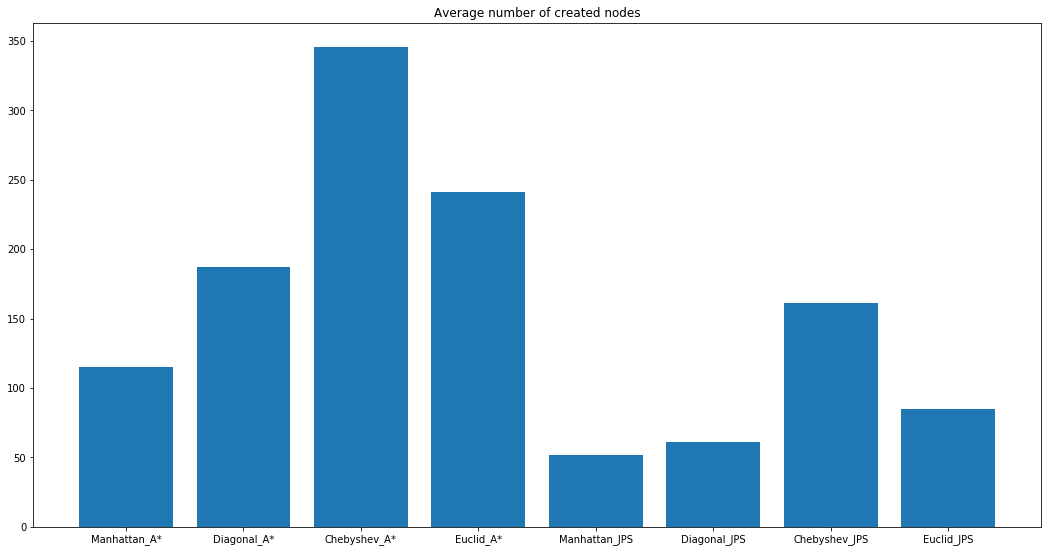

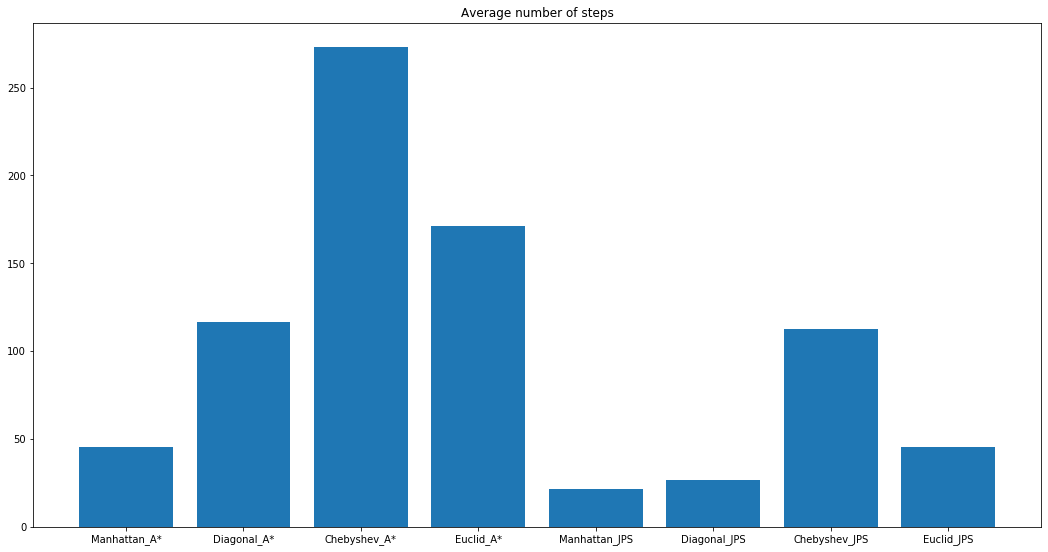

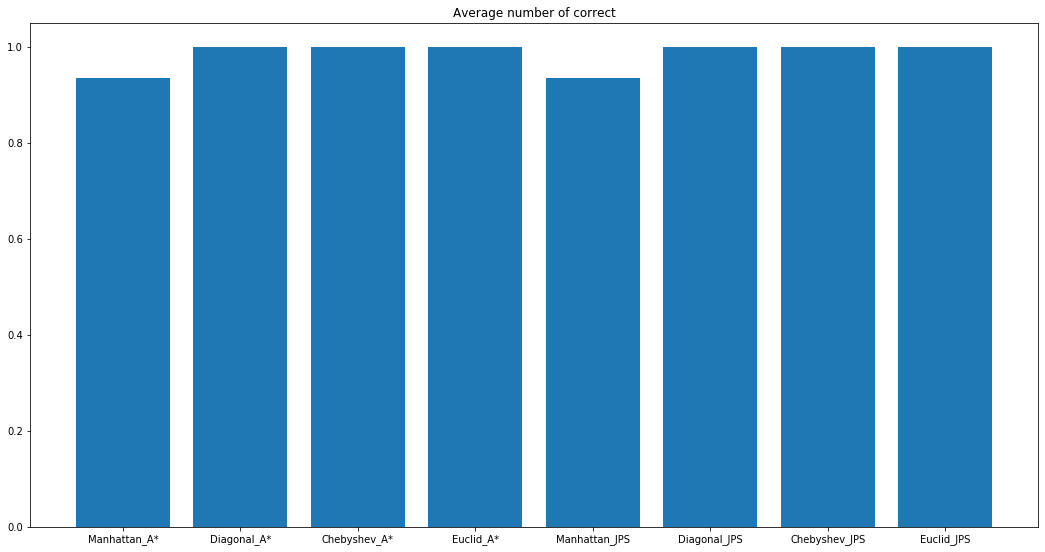

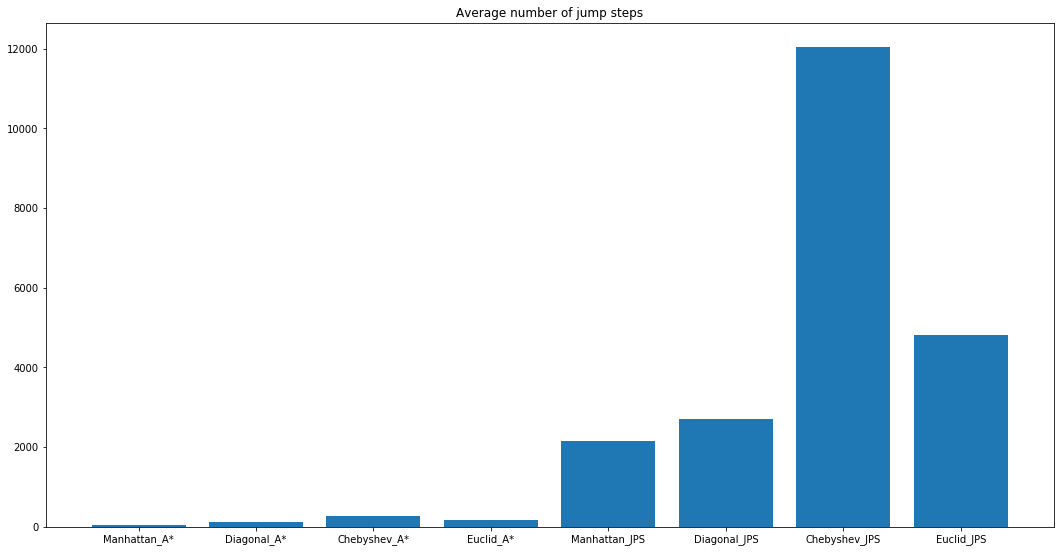

In [46]:
createdNodes = []
stepsNumber = []
correct = []
jumpSteps = []
results = [manh_mass, diag_mass, cheb_mass, eucl_mass,
           manh_mass_jump, diag_mass_jump, cheb_mass_jump, eucl_mass_jump]
for res in results:
    createdNodes.append(sum([x[0] + x[1] for x in res.values()]) / len(res.values()))
    stepsNumber.append(sum([x[1] for x in res.values()]) / len(res.values()))
    correct.append(sum([int(x[2]) for x in res.values()]) / len(res.values()))
    jumpSteps.append(sum([x[-1] for x in res.values()]) / len(res.values()))
# show results
fig = plt.figure(figsize=(14, 7))
ax = fig.add_axes([0,0,1,1])
ax.set_title('Average number of created nodes')
alg = ['Manhattan_A*', 'Diagonal_A*', 'Chebyshev_A*', 'Euclid_A*',
       'Manhattan_JPS', 'Diagonal_JPS', 'Chebyshev_JPS', 'Euclid_JPS']
ax.bar(alg, createdNodes)
plt.show()
fig.savefig('createdNodes.png')
fig = plt.figure(figsize=(14, 7))
ax = fig.add_axes([0,0,1,1])
ax.set_title('Average number of steps')
ax.bar(alg, stepsNumber)
plt.show()
fig.savefig('stepsNumber.png')
fig = plt.figure(figsize=(14, 7))
ax = fig.add_axes([0,0,1,1])
ax.set_title('Average number of correct')
ax.bar(alg, correct)
plt.show()
fig = plt.figure(figsize=(14, 7))
ax = fig.add_axes([0,0,1,1])
ax.set_title('Average number of jump steps')
ax.bar(alg, jumpSteps)
plt.show()

### Результаты
Эксперименты проводились на трех картах - arena.map, den001d.map, Berlin_0_256.map. В качестве заданий для каждой карты брались первые 150 заданий из соответствующего файла.
